In [1]:
import networkx as nx
import scipy.sparse as sp
import numpy as np
import graph_utils as utils
import torch
import torch
from collections import defaultdict
import numpy as np
import time
import json
import random

In [2]:
seed=114514
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.seed_all()

# **Read data**

In [3]:
loader = np.load('gene_with_label.npz')
train_ones = loader['edges']
labels=loader['labels']
print(len(train_ones))
print(train_ones[:5])
print(np.max(train_ones))
print(np.max(labels))
print(np.min(labels))

total_class=np.max(labels)

2872
[[  0  60]
 [  0 622]
 [  1 345]
 [  2  39]
 [  2  56]]
813
2
1


In [4]:
adj_sparse = np.zeros((np.max(train_ones)+1,np.max(train_ones)+1))
for e in train_ones:
    adj_sparse[e[0],e[1]]=1
    adj_sparse[e[1],e[0]]=1
    
adj_sparse = sp.coo_matrix(adj_sparse).tocsr()

lcc = utils.largest_connected_components(adj_sparse)
adj_sparse= adj_sparse[lcc,:][:,lcc]
_N = adj_sparse.shape[0]
print('n',_N)
_Edges=[]
for x in np.column_stack(adj_sparse.nonzero()):
    if not x[0]==x[1]:
        _Edges.append((x[0],x[1]))
_num_of_edges=int(len(_Edges)/2)
print('m',_num_of_edges)

dic=defaultdict(set)
for x in _Edges:
    a1=x[0]
    a2=x[1]
    dic[a1].add(a2)
    dic[a2].add(a1)
    

adj_origin=np.zeros((_N,_N)).astype(int)
for (i,j) in _Edges:
    adj_origin[i][j]=1
    adj_origin[j][i]=1
assert(np.sum(adj_origin==adj_origin.T)==_N*_N)
assert(np.sum(adj_origin)==_num_of_edges*2)

Selecting 1 largest connected components
n 814
m 1436


# **1.Get link prediction model and embedding**

In [5]:
embedding_dim=128

graphsagemodel=utils.GraphSAGE(_N=_N,_M=_num_of_edges,adj_origin=adj_origin,
                                         adj_dic=dic,embedding_dim=embedding_dim)


# *1.1 Load pretrained model*

In [6]:
graphsagemodel.load_model(path='graphsage.pth',embedding_path='embeddings_matrix.npy')

In [7]:
embedding_matrix_numpy=graphsagemodel.embedding_matrix_numpy
link_prediction_model=graphsagemodel.graphsage_link_prediction_from_embedding_one_to_other
predict_adj=utils.evaluate_overlap_torch(_N=_N,
                                                    _num_of_edges=_num_of_edges,
                                                    adj_origin=adj_origin,
                                                    embedding_matrix_numpy=embedding_matrix_numpy,
                                                    link_prediction_from_embedding_one_to_other=link_prediction_model)

813/814[(0.6239317, 114, 297), (0.6242199, 511, 797), (0.63082474, 120, 297), (0.6310142, 386, 802), (0.62630093, 477, 731), (0.6699211, 159, 305), (0.6359365, 408, 668), (0.6691241, 120, 166), (0.6322952, 120, 150), (0.63624847, 183, 769)]
1.0
(814, 814)
2872
2872
True Positve:2778, 0.97
False Positve:94, 0.03
True Negative:659630, 1.00
False Negative:94, 0.00
Positive:0.00
Negative:1.00


In [8]:
metric_embedding=utils.compute_graph_statistics(predict_adj)
metric_origin=utils.compute_graph_statistics(adj_origin)

Values less than or equal to 0 in data. Throwing out 0 or negative values
/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [9]:
for x in metric_origin:
    print('%-25s origin:%17.8f, link_pred:%17.8f'%(x,metric_origin[x],metric_embedding[x]))

d_max                     origin:      29.00000000, link_pred:      29.00000000
d_min                     origin:       1.00000000, link_pred:       0.00000000
d                         origin:       3.52825553, link_pred:       3.52825553
LCC                       origin:     814.00000000, link_pred:     806.00000000
wedge_count               origin:    7786.00000000, link_pred:    7526.00000000
claw_count                origin:   23322.00000000, link_pred:   21661.00000000
triangle_count            origin:     809.00000000, link_pred:     681.00000000
square_count              origin:     968.00000000, link_pred:     537.00000000
power_law_exp             origin:       2.05426571, link_pred:       2.03385673
gini                      origin:       0.42572701, link_pred:       0.41770239
rel_edge_distr_entropy    origin:       0.95303593, link_pred:       0.95496390
assortativity             origin:       0.13561540, link_pred:       0.03567548
clustering_coefficient    origin:       

In [10]:
augment_embeddings=np.zeros((embedding_matrix_numpy.shape[0],embedding_matrix_numpy.shape[1]+total_class))
augment_embeddings[:,:embedding_matrix_numpy.shape[1]]=embedding_matrix_numpy[:,:]

print(np.max(augment_embeddings))

for i in range(_N):
    augment_embeddings[i,128+labels[i]-1]=1

22.017864227294922


In [11]:
def compute_different(embeddings):
    different_idx=[]
    visited={}
    for i in range(len(embeddings)):
        if i not in visited:
            different_idx.append(i)
            visited[i]=True
            for j in range(i+1,len(embeddings)):
                if np.linalg.norm(embeddings[i]-embeddings[j])<1e-5:
                    if j not in visited:
                        visited[j]=True
        if i%100==0:
            print('\r%d/%d'%(i,_N),end="")
    return different_idx
different_idx=compute_different(augment_embeddings)
embeddings_training=augment_embeddings[different_idx,:]
print(embeddings_training.shape)
print(np.max(embeddings_training))

800/814(755, 130)
22.017864227294922


In [12]:
print(np.argmax(embeddings_training[:,128:],axis=1))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

# **2.GAN generate new embeddings**

In [13]:
batch_size=256
noise_dim=16
g_hidden_dim=[32,64,100]
d_hidden_dim=[100,64,32]
lendataloader=20
Diter=5
Giter=1
epoch_numbers=20000
eval_epoch=500


# **2.1 GAN training**

0


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

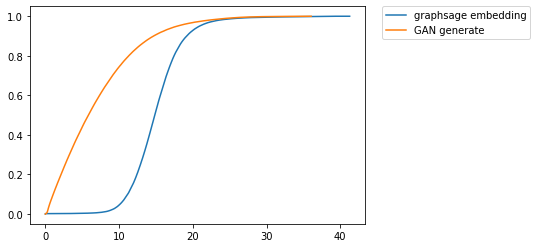

[[0.         0.         0.06721025 0.00066909 0.00746276]
 [0.         0.         0.32539815 0.         0.10371107]
 [0.         0.         0.26872495 0.         0.0775213 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.25332874
0.0005227655700217975
0.0021019575563211556
save: 0
mmd=0.254385,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

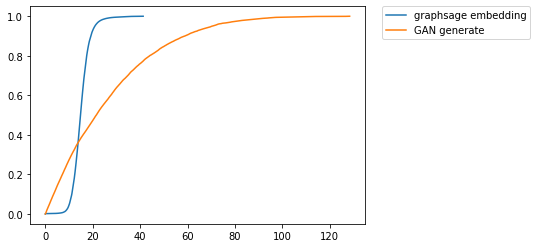

[[0.         0.         0.54175353 1.1813402  0.        ]
 [0.         0.         0.         0.         0.14051531]
 [0.         0.         0.         0.         0.158472  ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.07944203
0.00015060931158836064
0.0021019575563211556
save: 1
mmd=0.081243,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

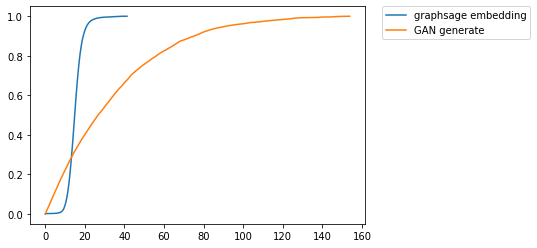

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.6639561  0.959168   0.02500354]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.063887775
0.0001085298730197956
0.0021019575563211556
save: 2
mmd=0.065773,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

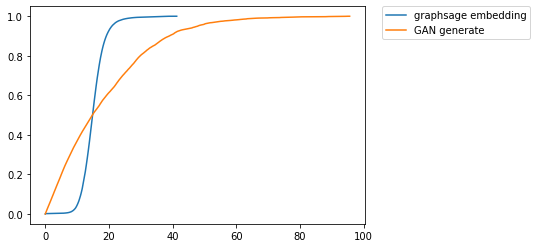

[[0.         0.         0.09790532 0.         0.        ]
 [0.         0.         0.2562475  0.         0.        ]
 [0.         0.         1.5566074  0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.111091144
0.00015779003813359976
0.0021019575563211556
save: 3
mmd=0.112878,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

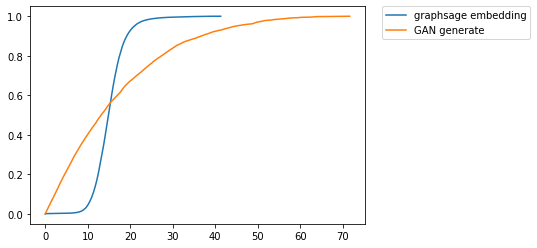

[[0.08377307 0.         0.         1.0156983  0.        ]
 [0.32368597 0.         0.         3.913368   0.        ]
 [0.07641309 0.         0.         0.92703944 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.1236322
0.00020642534201927674
0.0021019575563211556
save: 4
mmd=0.125321,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

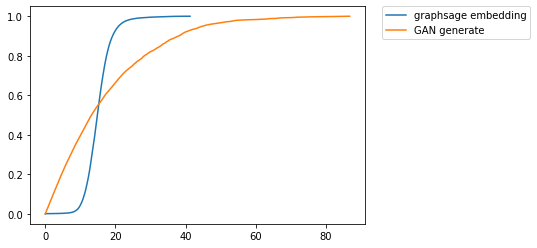

[[0.         0.         0.31175974 0.11340136 0.        ]
 [0.         0.         1.6795017  0.60557175 0.        ]
 [0.         0.         0.         0.0276414  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.121723115
0.00015077934595642835
0.0021019575563211556
save: 5
mmd=0.123524,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

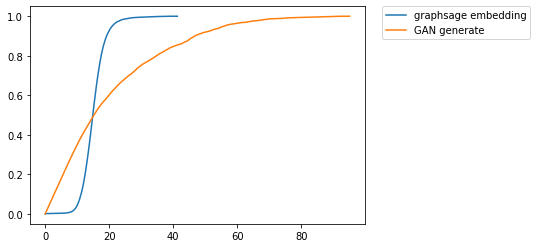

[[0.         0.         0.63917726 0.         0.        ]
 [0.         0.         0.         1.3314081  0.        ]
 [0.         0.         0.         5.8930016  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.10161526
9.472713637128956e-05
0.0021019575563211556
save: 6
mmd=0.103528,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

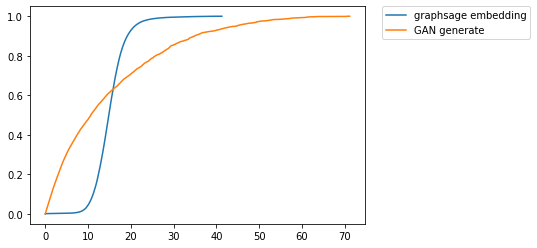

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.73359436 2.6230664  0.        ]
 [0.         0.         0.14998399 0.61729425 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.18194345
0.00014851926973383854
0.0021019575563211556
save: 7
mmd=0.183748,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/20000

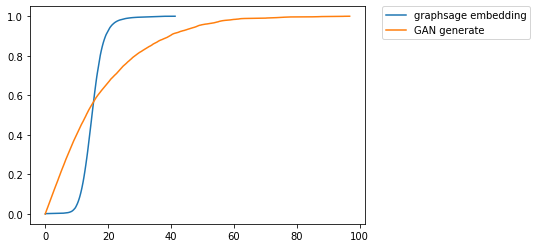

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.14857715 0.3628064  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.11998088
9.731627133888447e-05
0.0021019575563211556
save: 8
mmd=0.121888,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/20000

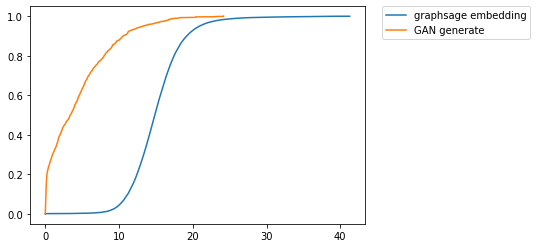

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7041963e-10 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.45408878
0.00011820663650386853
0.0021019575563211556
save: 9
mmd=0.455954,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5500/20000

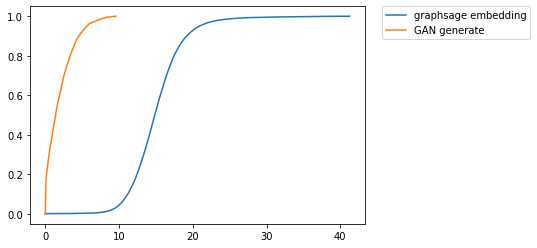

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1160555e-19 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.6870604
0.00013502527119154084
0.0021019575563211556
save: 10
mmd=0.688892,collapse=0.001335


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6000/20000

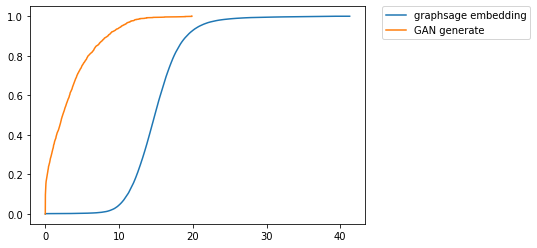

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.53116846
0.00022007210617867274
0.0021019575563211556
save: 11
mmd=0.532830,collapse=0.003475


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6500/20000

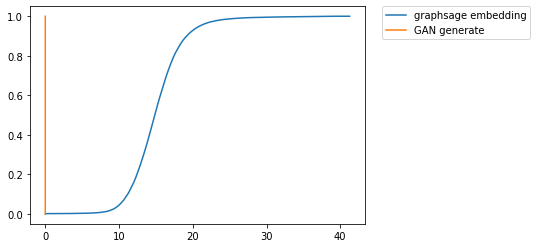

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899932019295614e-05
0.0021019575563211556
save: 12
mmd=1.002004,collapse=1.000000
Using time:1273.41
10000
10000
1


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

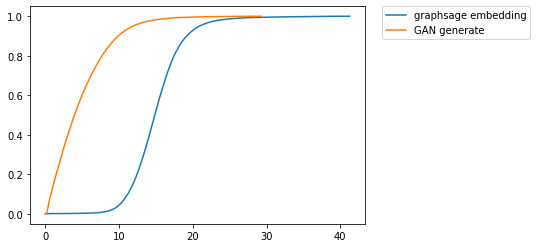

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3564242
0.0005721257776982377
0.0021019575563211556
save: 0
mmd=0.357382,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

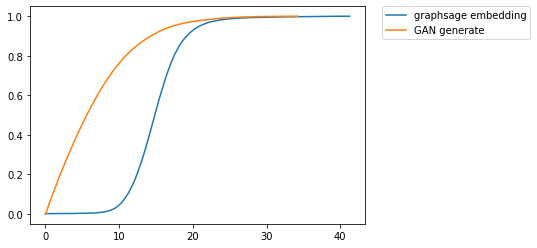

[[0.         0.         0.         0.86134726 0.        ]
 [0.         0.         0.         1.1793153  0.        ]
 [0.         0.         0.         1.3407768  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.26411164
0.0005113750768126318
0.0021019575563211556
save: 1
mmd=0.265191,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

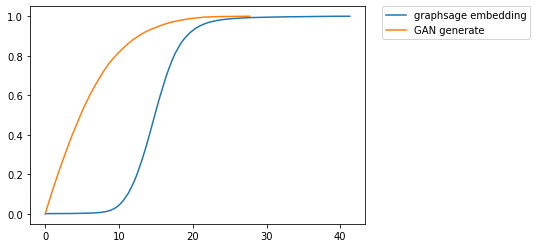

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1883972e-07 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.30716074
6.695185684222105e-05
0.0021019575563211556
save: 2
mmd=0.309129,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

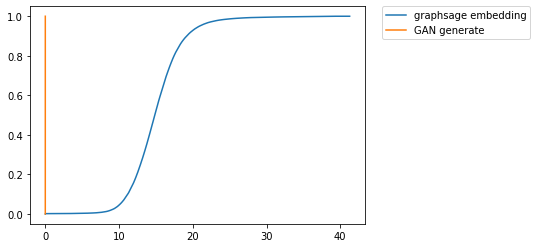

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.905543168094546e-05
0.0021019575563211556
save: 3
mmd=1.002004,collapse=0.157490


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

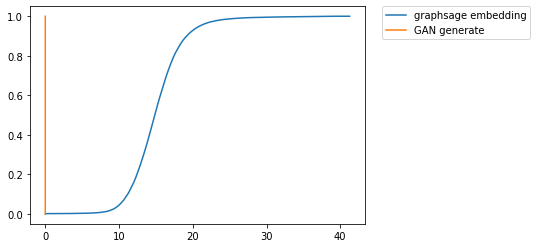

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930372307468e-05
0.0021019575563211556
save: 4
mmd=1.002004,collapse=1.000000


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Using time:483.56
10000
10000
2
Epoch:500/20000

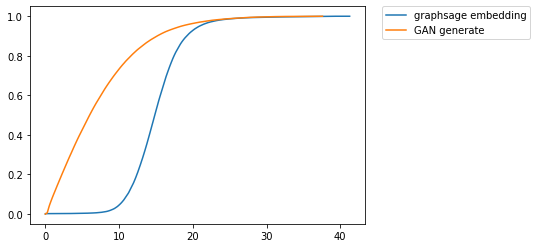

[[0.         0.         0.39201266 0.8463618  0.        ]
 [0.         0.         0.13429508 0.300669   0.        ]
 [0.         0.         0.52603227 1.0074991  0.07133497]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.24305087
0.00044549653676275553
0.0021019575563211556
save: 0
mmd=0.244262,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

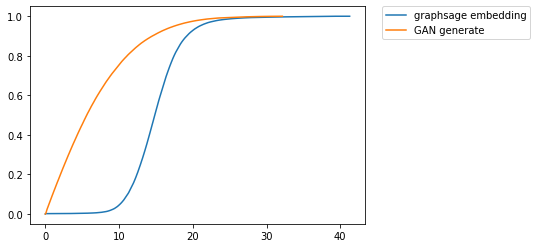

[[0.         0.         0.44568843 0.74430037 0.0561017 ]
 [0.         0.         0.67968    1.0633997  0.11570634]
 [0.         0.         0.28047183 0.42264012 0.05142469]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.26271406
0.0006115814356698115
0.0021019575563211556
save: 1
mmd=0.263593,collapse=0.001482


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

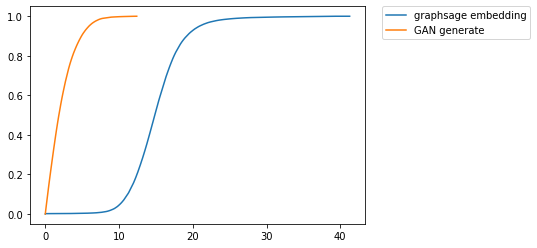

[[0.         0.         0.2231186  0.38335213 0.06224388]
 [0.         0.         0.0272891  0.04650547 0.00514453]
 [0.         0.         0.25068384 0.43311504 0.07114606]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.62255144
0.00043196526392788175
0.0021019575563211556
save: 2
mmd=0.623789,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

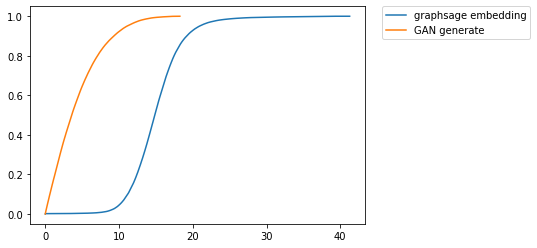

[[0.         0.         0.16900684 0.30239275 0.06598023]
 [0.         0.         0.03586639 0.06432228 0.01286839]
 [0.         0.         0.06346034 0.11358618 0.02410621]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.39069277
0.0006358192316944382
0.0021019575563211556
save: 3
mmd=0.391523,collapse=0.001328


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

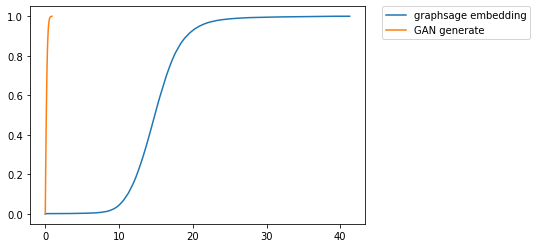

[[0.0000000e+00 0.0000000e+00 1.0080156e-03 1.1959330e-03 8.8956411e-05]
 [0.0000000e+00 0.0000000e+00 5.5774400e-04 6.1819726e-04 4.5929144e-05]
 [0.0000000e+00 0.0000000e+00 1.4300970e-03 1.7390860e-03 1.3116510e-04]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.99536103
6.365742139036236e-05
0.0021019575563211556
save: 4
mmd=0.997336,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

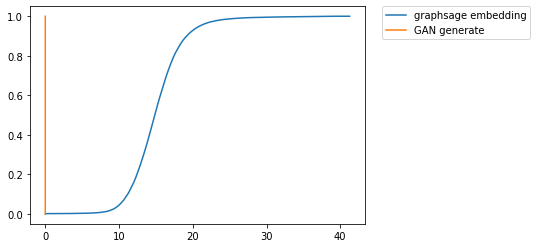

[[0.0000000e+00 0.0000000e+00 5.5137356e-14 2.6910642e-14 6.3223009e-15]
 [0.0000000e+00 0.0000000e+00 5.5137356e-14 2.6910642e-14 6.3223009e-15]
 [0.0000000e+00 0.0000000e+00 5.5137356e-14 2.6910642e-14 6.3223009e-15]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.8999303726857083e-05
0.0021019575563211556
save: 5
mmd=1.002004,collapse=1.000000


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Using time:577.58
10000
10000
3
Epoch:500/20000

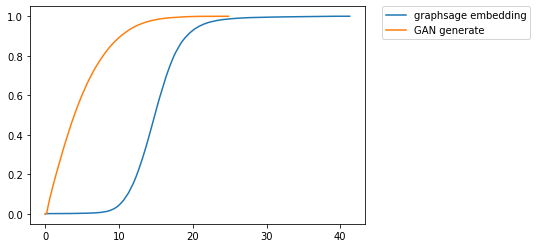

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.35735798
0.00022723430020852065
0.0021019575563211556
save: 0
mmd=0.359005,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

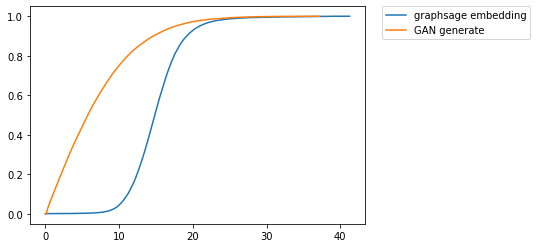

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.25564805
0.00027527305198631947
0.0021019575563211556
save: 1
mmd=0.257199,collapse=0.001346


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

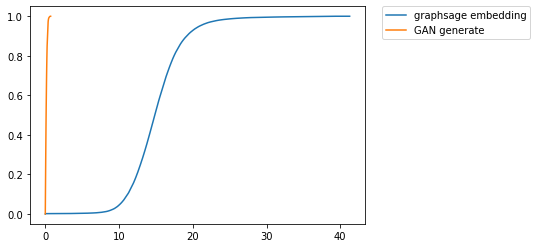

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.99701077
6.208610850293612e-05
0.0021019575563211556
save: 2
mmd=0.998989,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

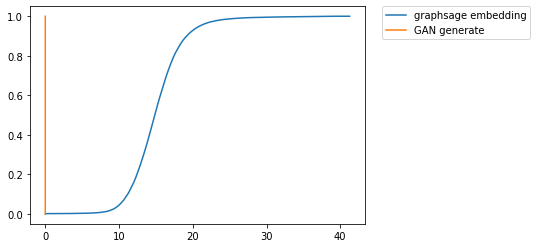

[[0.0000000e+00 0.0000000e+00 6.6166795e-34 2.2460595e-34 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.6166800e-34 2.2460701e-34 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.6166800e-34 2.2460692e-34 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.8999303734538385e-05
0.0021019575563211556
save: 3
mmd=1.002004,collapse=1.000000
Using time:386.03
10000
10000
4


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

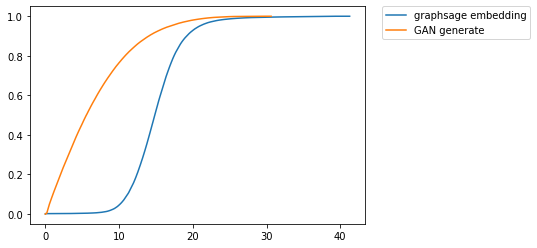

[[0.         0.         0.         0.4879282  0.        ]
 [0.         0.         0.         0.00654714 0.        ]
 [0.         0.         0.         0.54440665 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.26282957
0.0003839629874368049
0.0021019575563211556
save: 0
mmd=0.264164,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

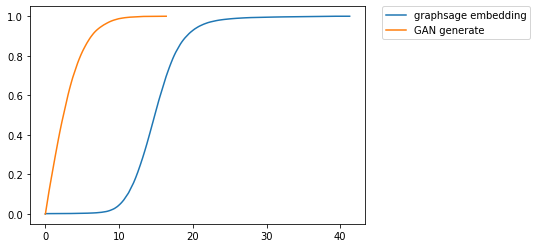

[[0.         0.         0.         1.6089971  0.        ]
 [0.         0.         0.         0.50129783 0.        ]
 [0.         0.         0.         0.34218958 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.52198213
0.0006400666227962354
0.0021019575563211556
save: 1
mmd=0.522804,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

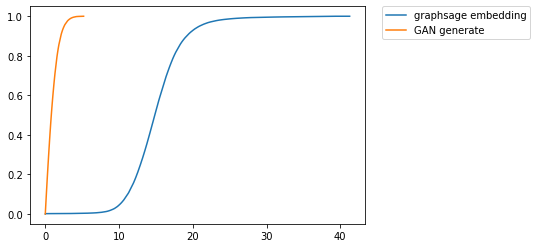

[[2.4093118e-23 0.0000000e+00 0.0000000e+00 1.6951939e-02 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0845185e-01 0.0000000e+00]
 [1.5105254e-23 0.0000000e+00 0.0000000e+00 2.0193391e-02 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.871093
0.00021310480045784276
0.0021019575563211556
save: 2
mmd=0.872769,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

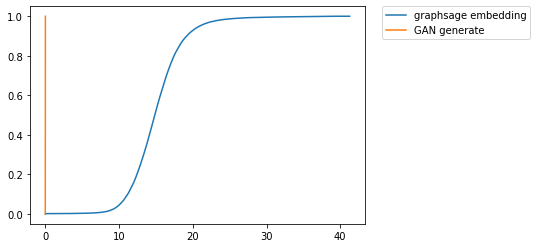

[[9.3486842e-32 0.0000000e+00 0.0000000e+00 1.3438040e-04 0.0000000e+00]
 [1.1429200e-31 0.0000000e+00 0.0000000e+00 3.0389565e-05 0.0000000e+00]
 [1.1468071e-31 0.0000000e+00 0.0000000e+00 2.9141203e-05 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.9999977
4.948968832932398e-05
0.0021019575563211556
save: 3
mmd=1.002001,collapse=0.015548


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

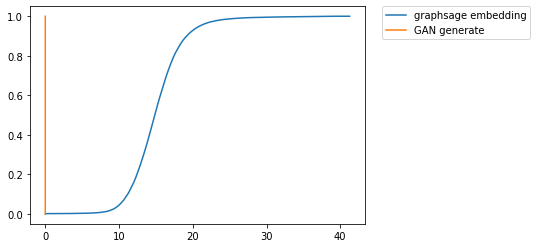

[[6.6630060e-40 0.0000000e+00 6.6278054e-40 2.6630585e-15 6.7921497e-40]
 [6.6630060e-40 0.0000000e+00 6.6278054e-40 2.6630585e-15 6.7921497e-40]
 [6.6630060e-40 0.0000000e+00 6.6278054e-40 2.6630585e-15 6.7921497e-40]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930372334454e-05
0.0021019575563211556
save: 4
mmd=1.002004,collapse=1.000000
Using time:482.02
10000
10000
5


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

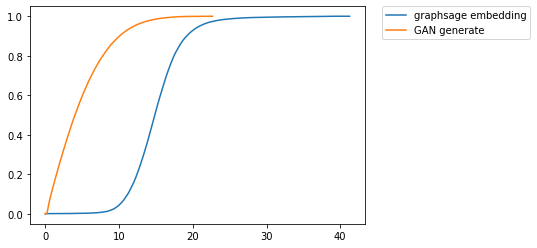

[[0.         0.         0.         0.791519   0.        ]
 [0.         0.         0.         0.7088569  0.        ]
 [0.         0.         0.         0.89878243 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3500318
0.0005610029702340466
0.0021019575563211556
save: 0
mmd=0.351012,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

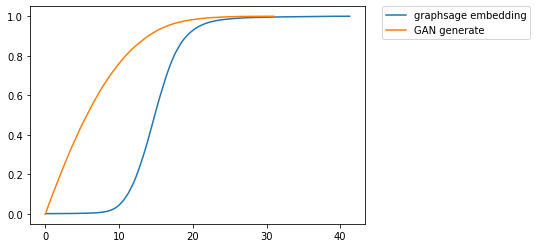

[[0.         0.         0.         1.4572088  0.        ]
 [0.         0.         0.         1.5029237  0.        ]
 [0.         0.         0.         0.37302262 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.26309046
0.00039604053466176756
0.0021019575563211556
save: 1
mmd=0.264400,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

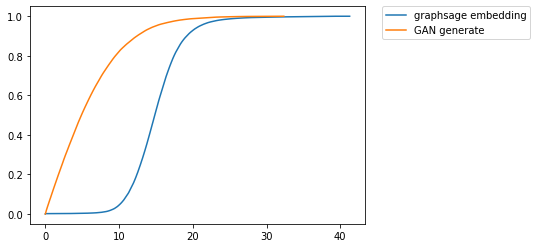

[[0.         0.         0.         0.02741036 0.        ]
 [0.         0.         0.         0.08991601 0.        ]
 [0.         0.         0.         0.5412476  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.29700267
0.0005650356008805177
0.0021019575563211556
save: 2
mmd=0.297975,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

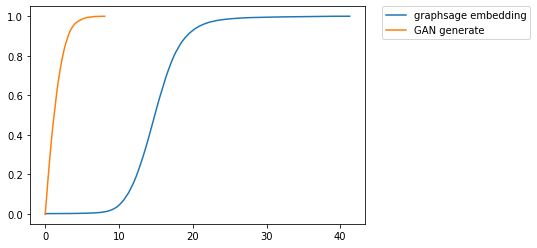

[[0.         0.         0.         0.00468039 0.        ]
 [0.         0.         0.         0.09159436 0.        ]
 [0.         0.         0.         0.10170853 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.7736274
0.00033311940633780357
0.0021019575563211556
save: 3
mmd=0.775063,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

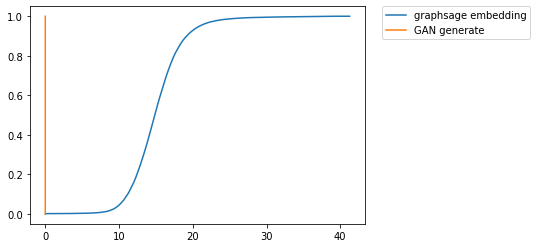

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.9062576419497466e-05
0.0021019575563211556
save: 4
mmd=1.002004,collapse=1.000000


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Using time:480.29
10000
10000
6
Epoch:500/20000

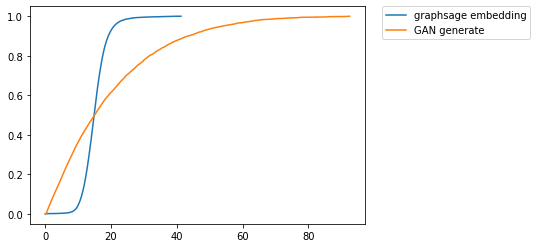

[[0.        0.        3.236275  7.264917  0.       ]
 [0.        0.        4.0527363 9.309937  0.       ]
 [0.        0.        0.        0.        1.2332605]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.10284303
0.00027465630270516635
0.0021019575563211556
save: 0
mmd=0.104396,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

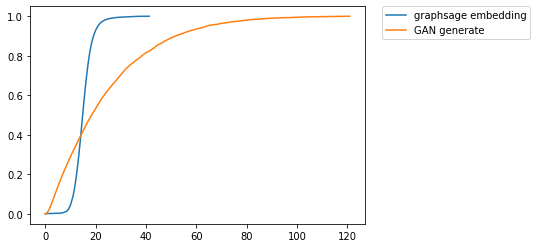

[[0.         0.         1.0134338  0.         0.        ]
 [0.         0.         2.1312916  4.9794245  0.03499201]
 [0.         0.         1.1249855  2.6049619  0.01988913]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.065405704
0.00014367689433159175
0.0021019575563211556
save: 1
mmd=0.067220,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

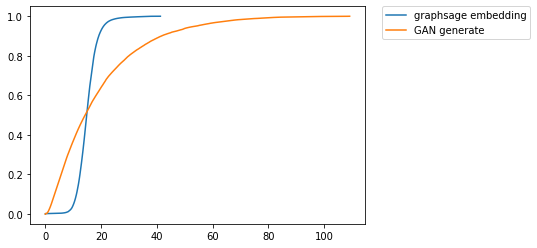

[[0.         0.         0.45734724 0.4796685  0.        ]
 [0.         0.         0.41844484 0.4412279  0.        ]
 [0.         0.         6.609276   2.856238   0.569497  ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.08031949
0.00037906207279166305
0.0021019575563211556
save: 2
mmd=0.081663,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

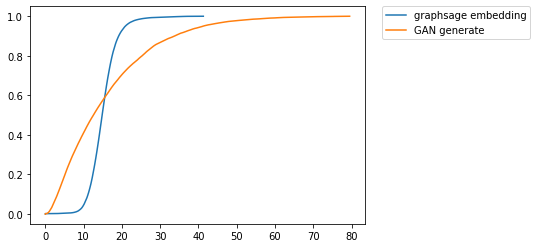

[[0.         0.         0.50995415 0.74361277 0.        ]
 [0.         0.         0.21971095 0.21002647 0.        ]
 [0.         0.         0.99837655 1.3488666  0.069502  ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.08679689
0.0002508205218292401
0.0021019575563211556
save: 3
mmd=0.088397,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

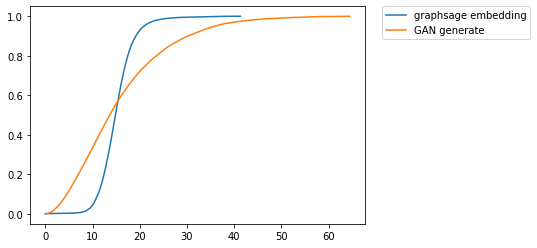

[[0.         0.         0.6314427  5.528188   0.        ]
 [0.         0.         0.37776607 0.         0.        ]
 [0.         0.         1.8298018  1.8399887  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.049626477
0.00029219398731220904
0.0021019575563211556
save: 4
mmd=0.051144,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

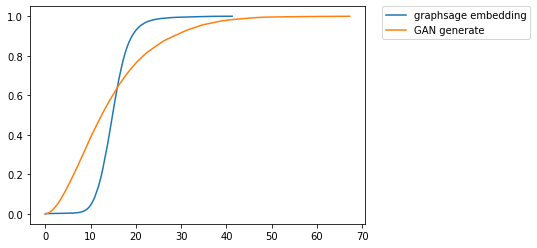

[[0.         0.         0.12321146 2.1084626  0.        ]
 [0.         0.         1.262469   0.50519794 0.03323082]
 [0.         0.         0.6146369  0.68644774 0.00879614]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.06112517
0.0004459779554107861
0.0021019575563211556
save: 5
mmd=0.062335,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

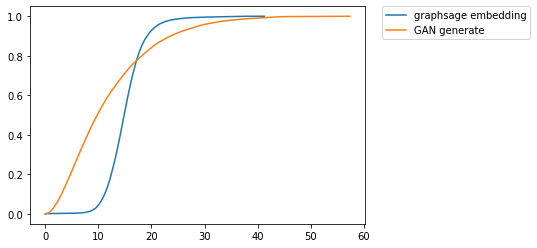

[[0.         0.         0.6463944  2.0923543  0.09380151]
 [0.         0.         0.02194297 0.5090913  0.0026256 ]
 [0.         0.         0.6257853  0.         0.1109431 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.09628555
0.00047827582158443857
0.0021019575563211556
save: 6
mmd=0.097431,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

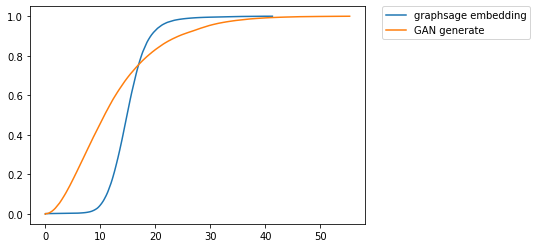

[[0.         0.         0.         0.14424725 0.        ]
 [0.         0.         2.2927063  3.0951674  1.4251766 ]
 [0.         0.         0.58776015 2.1499577  0.41499457]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.07379215
0.00015446984573682344
0.0021019575563211556
save: 7
mmd=0.075585,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/20000

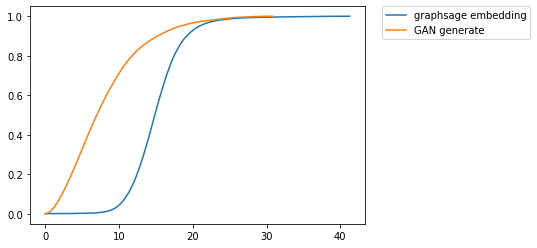

[[0.         0.         0.22172956 0.23702243 0.        ]
 [0.         0.         0.01936526 0.15520485 0.        ]
 [0.         0.         0.         0.08488996 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.15072629
0.00021547257604150814
0.0021019575563211556
save: 8
mmd=0.152397,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/20000

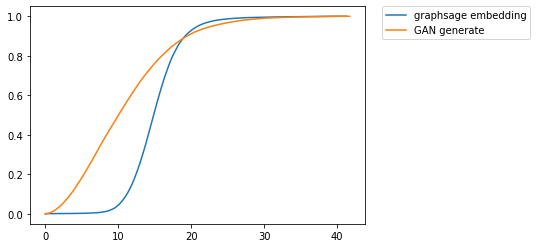

[[0.         0.         0.         0.03841302 0.        ]
 [0.         0.         0.         0.06849536 0.        ]
 [0.         0.         0.         1.4346594  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.07952228
0.00015338711797596325
0.0021019575563211556
save: 9
mmd=0.081317,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5500/20000

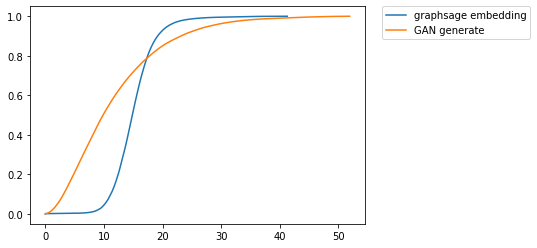

[[0.         0.         1.2917094  0.93469244 0.4818129 ]
 [0.         0.         2.3547728  1.5213803  0.65867126]
 [0.         0.         1.3878698  0.93085027 0.4060497 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.09364474
0.0001536138189876599
0.0021019575563211556
save: 10
mmd=0.095439,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6000/20000

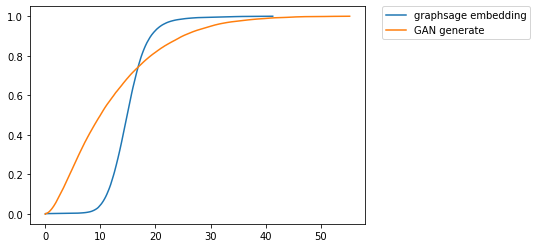

[[0.         0.         0.         0.02967975 0.        ]
 [0.         0.         0.         0.8021344  0.        ]
 [0.         0.         0.         0.94926643 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.10997243
0.00021494656866390913
0.0021019575563211556
save: 11
mmd=0.111644,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6500/20000

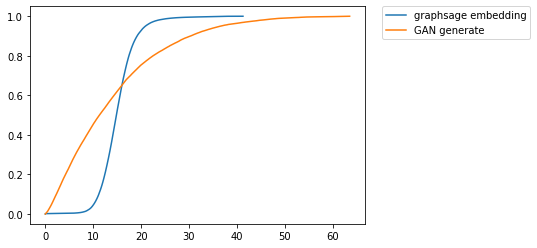

[[0.         0.         0.15423891 0.3743025  0.        ]
 [0.         0.         0.18491846 0.14840935 0.        ]
 [0.         0.         0.7343587  0.66141486 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.12594126
0.0001929866354589247
0.0021019575563211556
save: 12
mmd=0.127657,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7000/20000

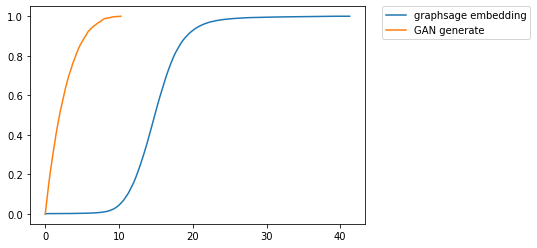

[[0.00000000e+00 0.00000000e+00 6.52155578e-02 1.12201115e-02
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.13698506e-03
  5.40663311e-20]
 [0.00000000e+00 0.00000000e+00 9.19784456e-02 5.72935082e-02
  0.00000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.5975181
0.0001609673936173482
0.0021019575563211556
save: 13
mmd=0.599298,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7500/20000

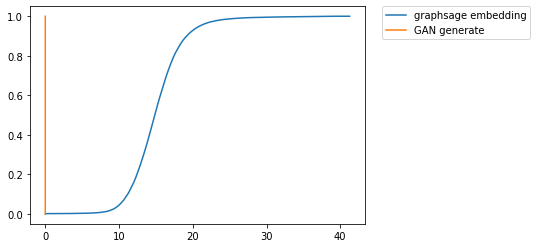

[[0.0000000e+00 0.0000000e+00 1.3600352e-12 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.3661371e-12 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.3653553e-12 6.7469224e-15 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899931321808928e-05
0.0021019575563211556
save: 14
mmd=1.002004,collapse=1.000000
Using time:1442.34
10000
10000
7


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

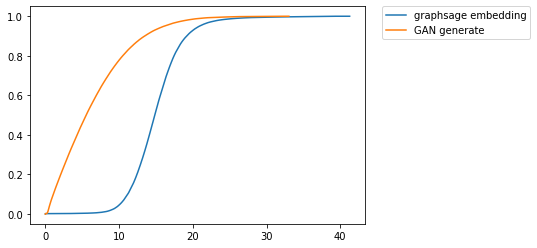

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.19527711]
 [0.         0.         0.         0.         0.01809821]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.26034892
0.0004817853865629569
0.0021019575563211556
save: 0
mmd=0.261487,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

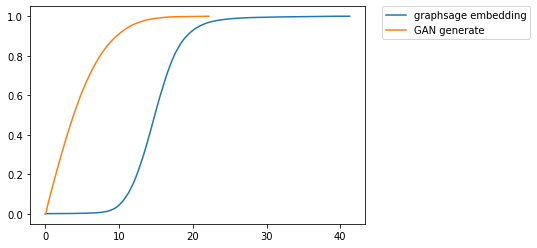

[[0.         0.         0.         0.         0.0559796 ]
 [0.         0.         0.         0.         0.01167861]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.36638233
0.0007434522805706556
0.0021019575563211556
save: 1
mmd=0.366997,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

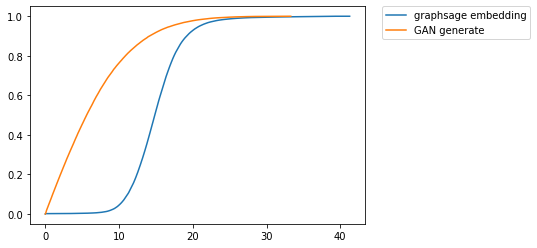

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3108803e-09 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.26269343
0.00045817347385198573
0.0021019575563211556
save: 2
mmd=0.263879,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

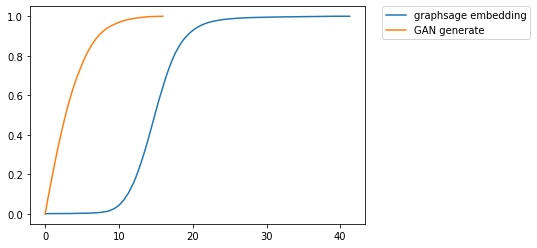

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9949251e-18 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1558126e-18 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.47918344
0.0005239372792261109
0.0021019575563211556
save: 3
mmd=0.480238,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

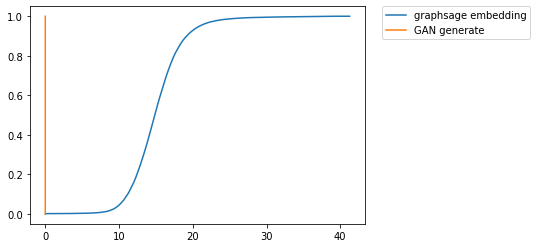

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 6.9390108e-27 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 6.9390324e-27 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 6.9389915e-27 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899931006798607e-05
0.0021019575563211556
save: 4
mmd=1.002004,collapse=1.000000
Using time:483.54
10000
10000
8


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

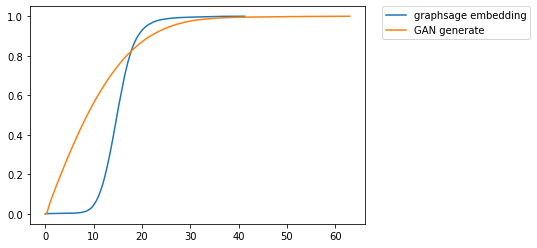

[[0.         0.         1.0273988  0.96429527 0.        ]
 [0.         0.         1.7778591  1.8326359  0.        ]
 [0.         0.         2.4705703  2.3310485  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.17160057
0.00035848082140300334
0.0021019575563211556
save: 0
mmd=0.172986,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

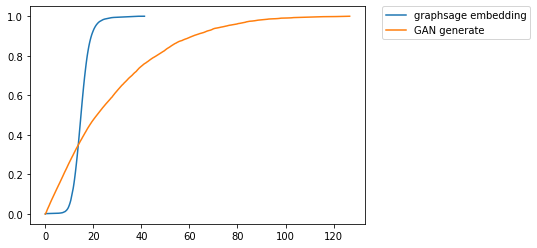

[[0.         0.         2.8450549  3.167435   0.3343184 ]
 [0.         0.         3.5423944  3.971741   0.40958458]
 [0.         0.         1.9341046  2.1521091  0.22302595]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.074529044
0.00012838545678954985
0.0021019575563211556
save: 1
mmd=0.076374,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

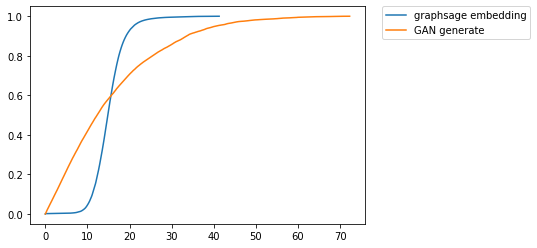

[[0.         0.         0.         0.         0.        ]
 [0.         0.         1.8166085  1.4001447  0.16404477]
 [0.         0.         0.29966274 0.22888674 0.02821763]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.121474385
0.00021961773251024131
0.0021019575563211556
save: 2
mmd=0.123137,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

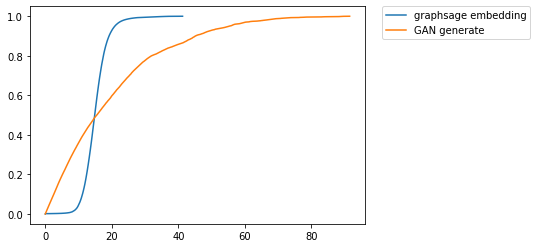

[[0.         0.         4.274792   5.2093434  1.0148757 ]
 [0.         0.         0.3272038  0.4139102  0.07451343]
 [0.         0.         0.0693827  0.11136913 0.01353146]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.10911495
0.00011072788234304276
0.0021019575563211556
save: 3
mmd=0.110995,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

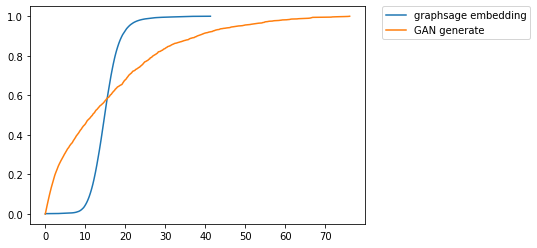

[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        1.8770424 2.4354005 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.20409666
0.00014397123419443946
0.0021019575563211556
save: 4
mmd=0.205911,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

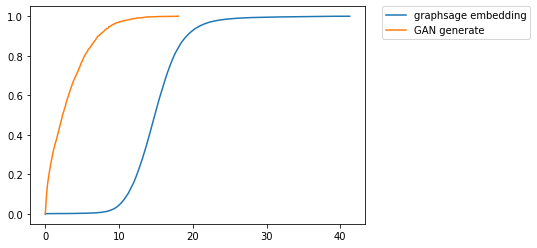

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.21996255 0.12917188 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.5319803
0.00017131059394916948
0.0021019575563211556
save: 5
mmd=0.533740,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

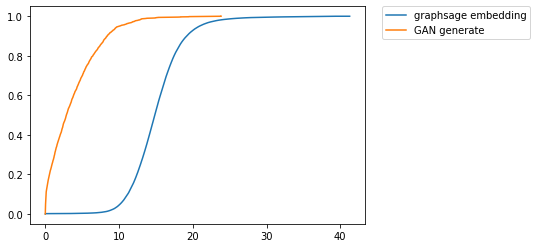

[[0.         0.         0.         0.10720363 0.        ]
 [0.         0.         0.         0.14970444 0.        ]
 [0.         0.         0.         0.09424311 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.47540596
0.0002561084791077453
0.0021019575563211556
save: 6
mmd=0.476996,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

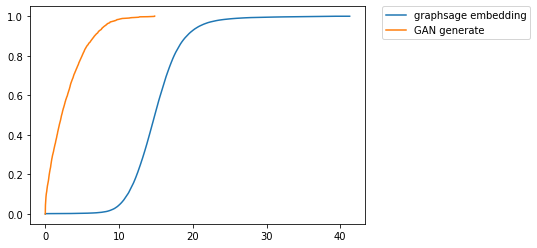

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2920980e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.4138473e-02 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.3093923e-10 1.3486074e-02 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.5487704
0.0001411502805194411
0.0021019575563211556
save: 7
mmd=0.550590,collapse=0.001503


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/20000

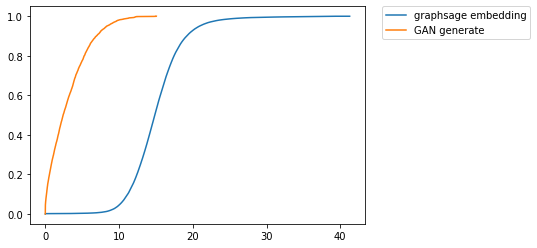

[[0.0000000e+00 0.0000000e+00 2.2814506e-18 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 8.2332110e-03 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.8921816e-01 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.5234587
0.00017292875325591658
0.0021019575563211556
save: 8
mmd=0.525215,collapse=0.001774


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/20000

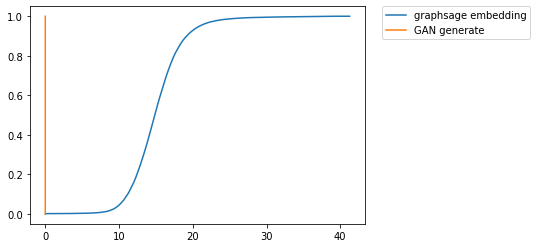

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899932627622064e-05
0.0021019575563211556
save: 9
mmd=1.002004,collapse=1.000000
Using time:963.54
10000
10000
9


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

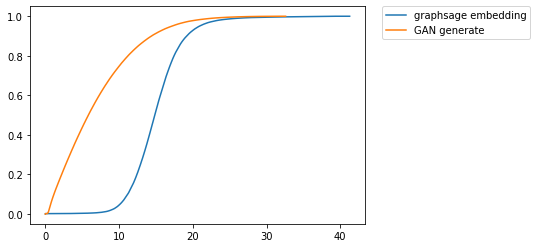

[[0.04037919 0.         0.6346006  0.94650376 0.        ]
 [0.01657894 0.         0.256176   0.43573135 0.        ]
 [0.03202104 0.         0.4643041  0.76772994 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.24659081
0.0008062579265617339
0.0021019575563211556
save: 0
mmd=0.247080,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

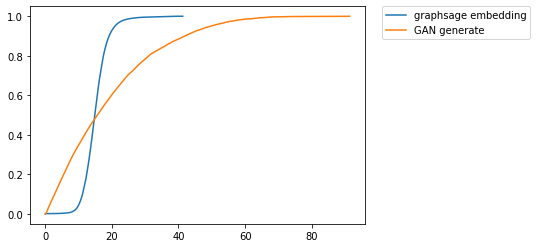

[[0.         0.         0.         5.1317697  0.44850132]
 [0.         0.         0.         0.7776729  0.05585616]
 [0.         0.         0.         2.29535    0.18842098]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.10019142
0.00021873525576470275
0.0021019575563211556
save: 1
mmd=0.101856,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

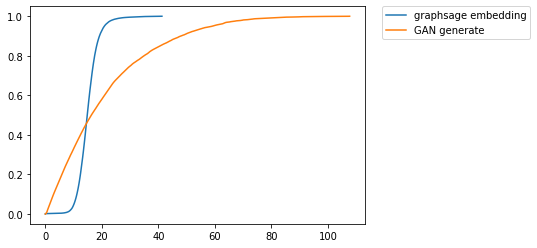

[[0.         0.         0.50902486 1.6190072  0.        ]
 [0.         0.         0.48153174 1.5827783  0.        ]
 [0.         0.         1.2926824  4.779343   0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.093724154
0.000265529292484438
0.0021019575563211556
save: 2
mmd=0.095295,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

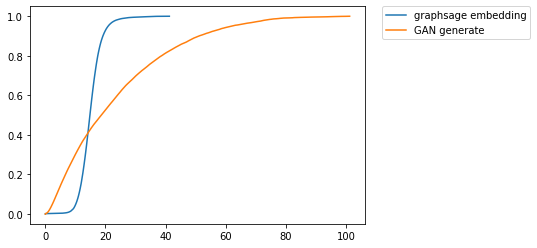

[[0.         0.         0.01365701 5.6946445  0.        ]
 [0.         0.         0.         0.71761066 0.        ]
 [0.         0.         0.         1.7276368  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.06733517
0.0003002796796682585
0.0021019575563211556
save: 3
mmd=0.068837,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

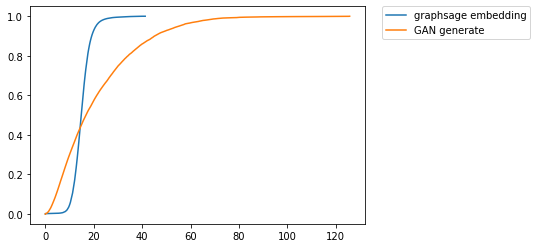

[[0.         0.         0.2254996  1.0007368  0.        ]
 [0.         0.         0.16133952 0.26011878 0.        ]
 [0.         0.         0.42674357 1.1923817  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.05144369
0.00025335037976676996
0.0021019575563211556
save: 4
mmd=0.053039,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

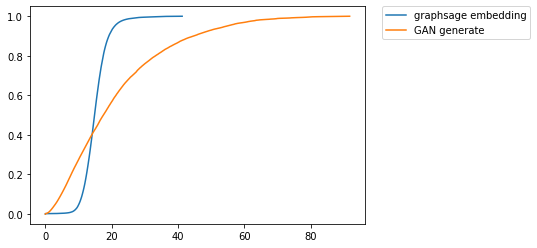

[[0.         0.         0.63217974 2.344173   0.6248735 ]
 [0.         0.         0.83529633 0.18377371 0.        ]
 [0.         0.         3.5966036  0.5961346  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.048019703
0.00025747909614612667
0.0021019575563211556
save: 5
mmd=0.049607,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

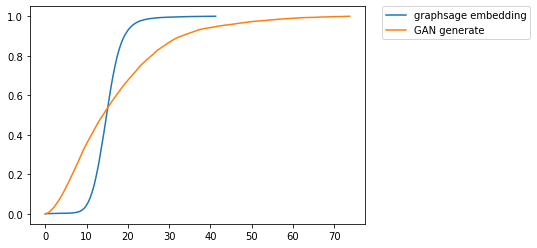

[[0.         0.         1.777295   1.2103949  0.        ]
 [0.         0.         1.0003604  0.84368116 0.18750261]
 [0.         0.         2.6846383  1.7766739  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.06032977
0.00021804594285890287
0.0021019575563211556
save: 6
mmd=0.061996,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

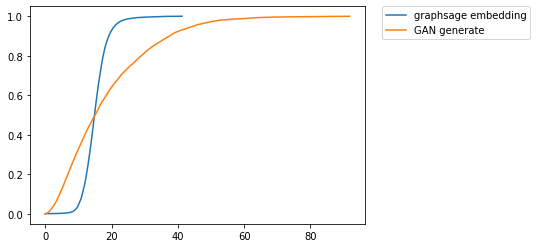

[[0.         0.         0.         0.2661985  0.01694089]
 [0.         0.         1.5552566  0.7312023  0.15696315]
 [0.         0.         1.8355147  0.5216383  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.05567952
0.00029980860058677626
0.0021019575563211556
save: 7
mmd=0.057182,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/20000

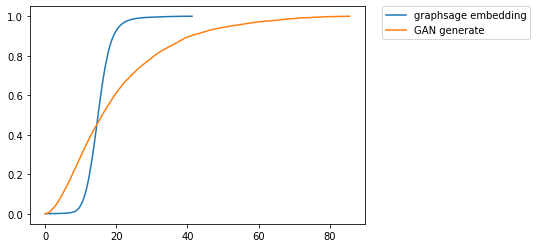

[[0.         0.         0.         1.3146744  0.10417935]
 [0.         0.         0.45986825 3.5860057  0.32799736]
 [0.         0.         0.         0.9443642  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.046788327
0.00025478056216961595
0.0021019575563211556
save: 8
mmd=0.048381,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/20000

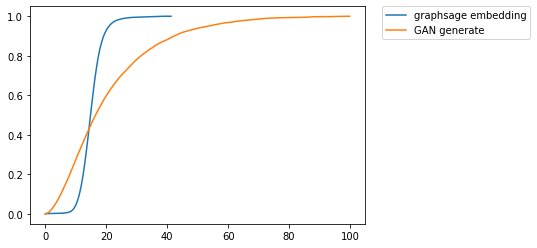

[[0.        0.        0.        3.5465689 0.       ]
 [0.        0.        0.        3.8211634 0.       ]
 [0.        0.        0.        4.077805  0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.04337976
0.0001038810132352747
0.0021019575563211556
save: 9
mmd=0.045274,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5500/20000

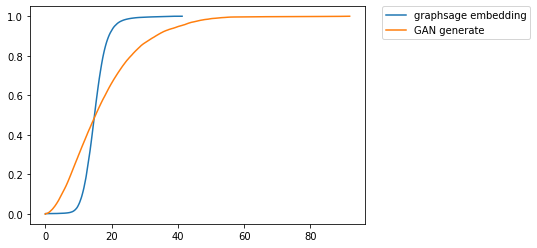

[[0.        0.        1.8237433 0.        0.       ]
 [0.        0.        1.014751  2.4582727 0.       ]
 [0.        0.        0.595018  0.8419507 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.043292604
6.252458116985153e-05
0.0021019575563211556
save: 10
mmd=0.045270,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6000/20000

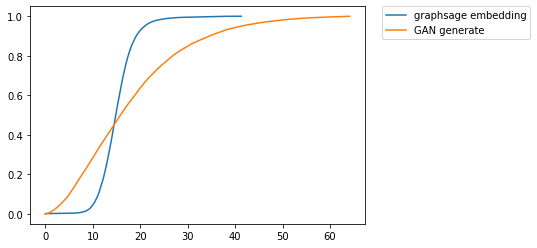

[[0.         0.         0.15530875 0.44874772 0.        ]
 [0.         0.         0.         1.7285814  0.        ]
 [0.         0.         0.2593743  0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.044604696
4.6794036845480856e-05
0.0021019575563211556
save: 11
mmd=0.046613,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6500/20000

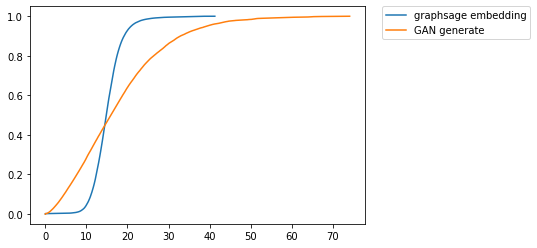

[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.8578966 0.       ]
 [0.        0.        0.        0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.052410334
6.30751591576908e-05
0.0021019575563211556
save: 12
mmd=0.054386,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7000/20000

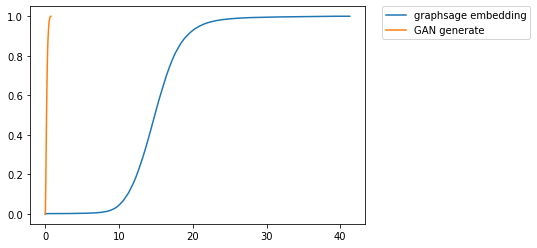

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 4.227039e-06 0.000000e+00 0.000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.9943817
5.55419396889801e-05
0.0021019575563211556
save: 13
mmd=0.996373,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7500/20000

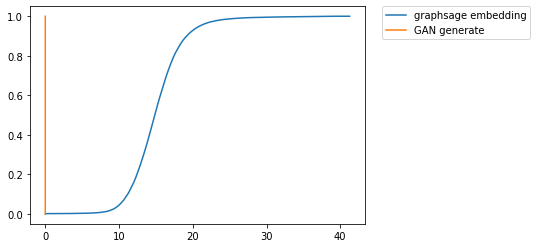

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930373646876e-05
0.0021019575563211556
save: 14
mmd=1.002004,collapse=1.000000
Using time:1446.27
10000
10000
10


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

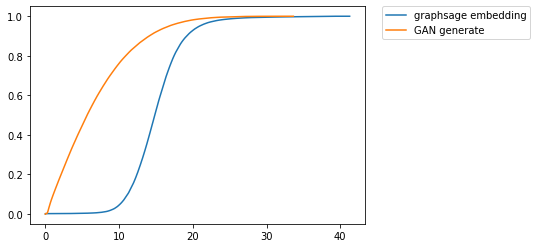

[[0.         0.         1.0530668  0.         0.        ]
 [0.         0.         0.89561456 0.         0.        ]
 [0.         0.         1.1861145  0.         0.0221376 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.25530374
0.000549467325303938
0.0021019575563211556
save: 0
mmd=0.256307,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

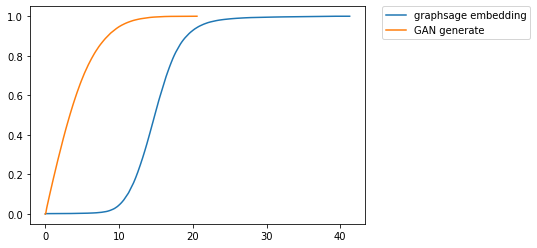

[[0.         0.         0.5336351  0.         0.00934784]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.62049145 0.         0.02423001]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.41272742
0.000901117891862788
0.0021019575563211556
save: 1
mmd=0.413027,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

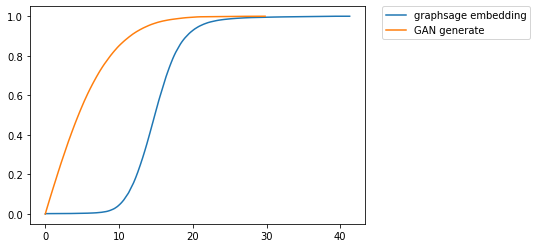

[[0.        0.        1.1511186 0.        0.       ]
 [0.        0.        0.559137  0.        0.       ]
 [0.        0.        0.3583403 0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.32108667
0.00038755729016853787
0.0021019575563211556
save: 2
mmd=0.322414,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

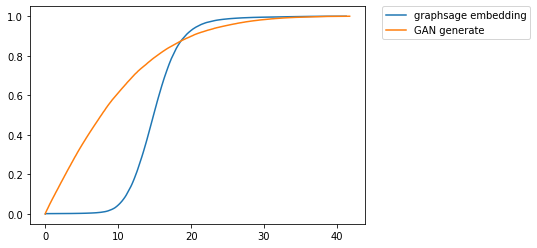

[[0.         0.         2.0518343  0.         0.8210529 ]
 [0.         0.         2.0366766  0.         0.8161223 ]
 [0.         0.         1.3391199  0.         0.54021126]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.20045123
0.0001736771579803899
0.0021019575563211556
save: 3
mmd=0.202206,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

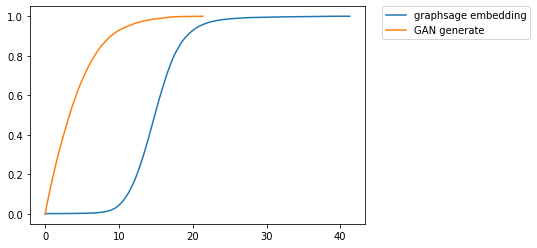

[[2.5145894e-09 1.4989784e-04 2.5530346e-04 0.0000000e+00 0.0000000e+00]
 [7.2632194e-09 3.8482179e-04 3.7840835e-04 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2307692e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.42205706
8.178316506235137e-05
0.0021019575563211556
save: 4
mmd=0.423995,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

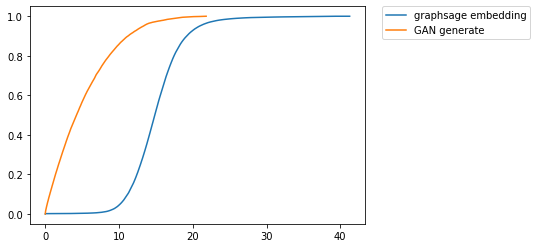

[[0.         0.         0.2989666  0.         0.        ]
 [0.         0.         0.16509648 0.         0.        ]
 [0.         0.         0.3945613  0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3494608
0.00025790854663503135
0.0021019575563211556
save: 5
mmd=0.351047,collapse=0.001349


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

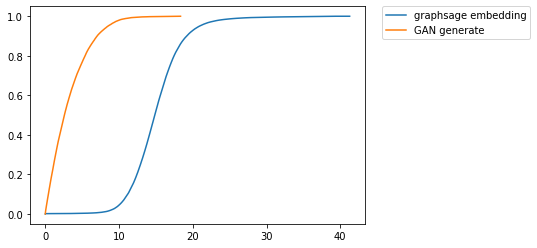

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.49861008
0.0002374209073491496
0.0021019575563211556
save: 6
mmd=0.500237,collapse=0.001342


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

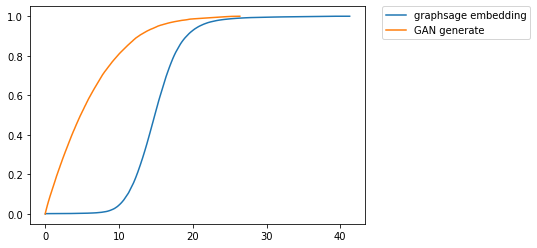

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.31307504
0.00029177709605914876
0.0021019575563211556
save: 7
mmd=0.314593,collapse=0.001370


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/20000

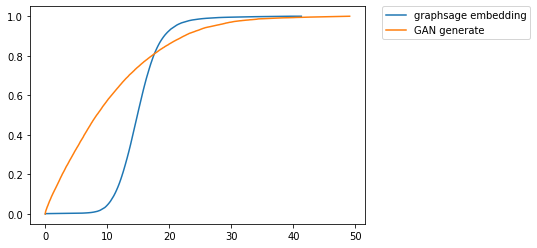

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [2.3304490e-39 2.3306396e-39 6.8275035e-21 0.0000000e+00 2.0519956e-39]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.19957246
0.00018619333044791632
0.0021019575563211556
save: 8
mmd=0.201302,collapse=0.001946


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/20000

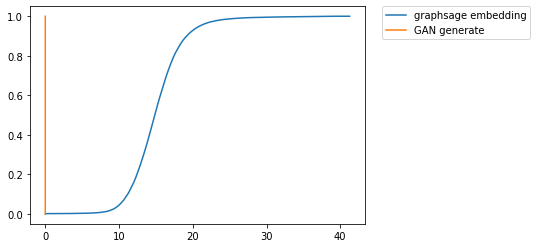

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930459645016e-05
0.0021019575563211556
save: 9
mmd=1.002004,collapse=1.000000


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Using time:966.01
10000
10000
11
Epoch:500/20000

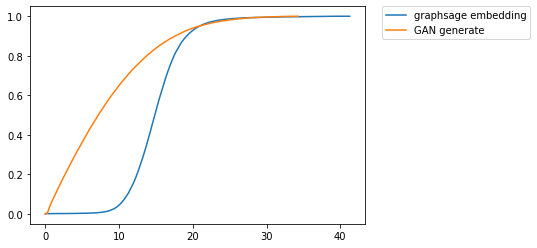

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.20548421
0.00040809936631506285
0.0021019575563211556
save: 0
mmd=0.206770,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

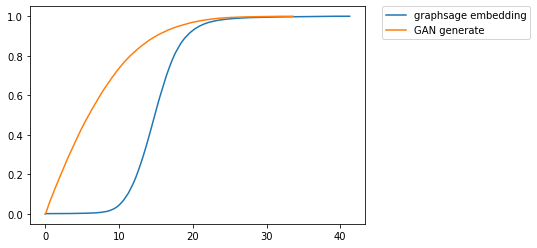

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.25511754
0.0005251565999319619
0.0021019575563211556
save: 1
mmd=0.256169,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

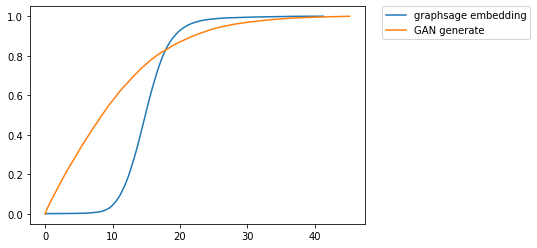

[[0.         0.         0.         0.         0.00221123]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.08292235]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.18879326
0.00040191502723599165
0.0021019575563211556
save: 2
mmd=0.190091,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

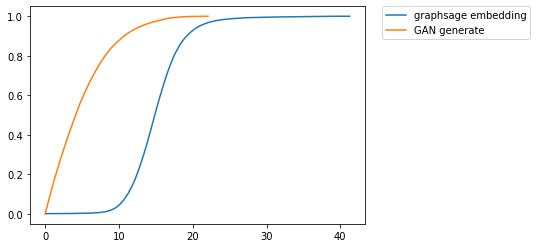

[[0.         0.         0.         0.         0.04659812]
 [0.         0.         0.         0.         0.1727055 ]
 [0.         0.         0.         0.         0.0110741 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.35082966
0.0004837611334421452
0.0021019575563211556
save: 3
mmd=0.351964,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

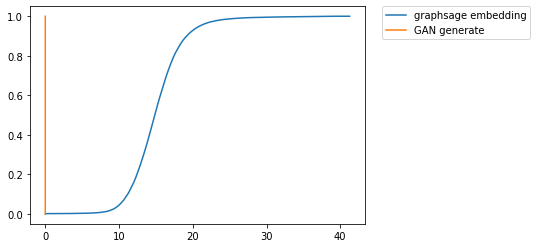

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2309526e-11]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2309359e-11]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2311115e-11]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899931699736488e-05
0.0021019575563211556
save: 4
mmd=1.002004,collapse=1.000000


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Using time:482.53
10000
10000
12
Epoch:500/20000

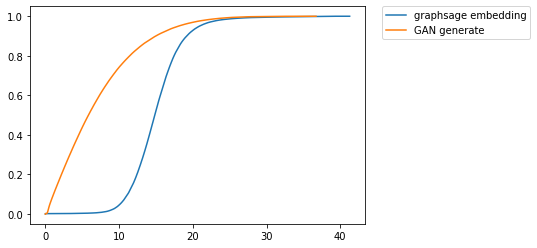

[[0.        0.        0.        0.8888706 0.       ]
 [0.        0.        0.        0.5857247 0.       ]
 [0.        0.        0.        0.7124588 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.24896312
0.0005060564454520085
0.0021019575563211556
save: 0
mmd=0.250053,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

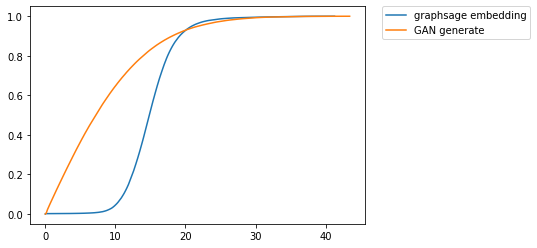

[[0.        0.        0.        0.7334145 0.       ]
 [0.        0.        0.        1.2122662 0.       ]
 [0.        0.        0.        0.6791349 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.2073893
0.00038050618855412155
0.0021019575563211556
save: 1
mmd=0.208730,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

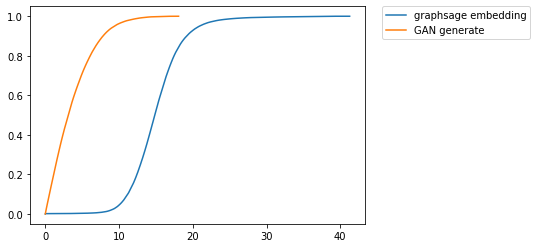

[[0.         0.         0.         0.38486373 0.        ]
 [0.         0.         0.         0.11335529 0.        ]
 [0.         0.         0.         0.9714275  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.43667433
0.000771188086998841
0.0021019575563211556
save: 2
mmd=0.437234,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

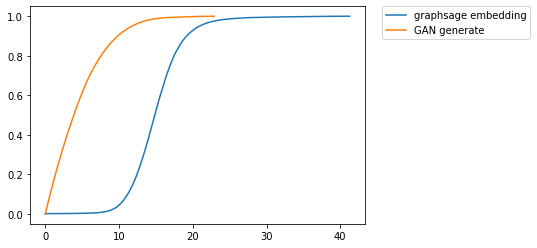

[[0.         0.         0.         0.10017008 0.        ]
 [0.         0.         0.         0.59983325 0.        ]
 [0.         0.         0.         1.0346068  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.36920443
0.0006422884199432993
0.0021019575563211556
save: 3
mmd=0.370022,collapse=0.001328


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

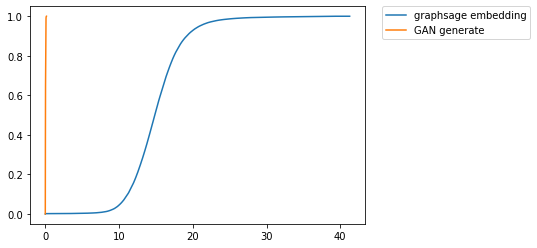

[[0.0000000e+00 0.0000000e+00 5.4036311e-40 3.5890652e-04 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.0928037e-40 1.9538202e-04 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.2944085e-40 1.4517836e-04 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.9998614
5.251971899627373e-05
0.0021019575563211556
save: 4
mmd=1.001858,collapse=0.001630


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

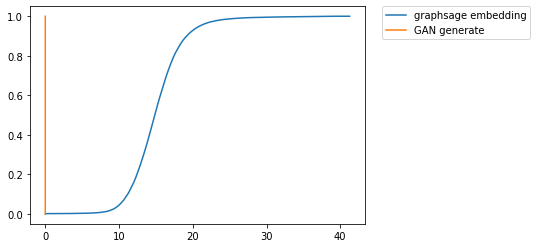

[[0.0000000e+00 0.0000000e+00 6.7121075e-40 5.4231027e-14 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.7121075e-40 5.4231027e-14 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.7121075e-40 5.4231027e-14 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930376189334e-05
0.0021019575563211556
save: 5
mmd=1.002004,collapse=1.000000
Using time:587.22
10000
10000
13


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

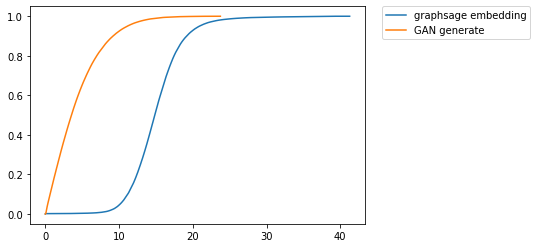

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3912008
9.022324401017697e-05
0.0021019575563211556
save: 0
mmd=0.393122,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

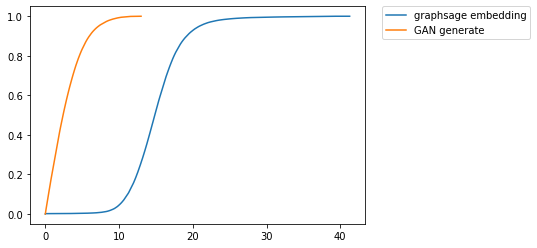

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.5297538
0.00040776968582630064
0.0021019575563211556
save: 1
mmd=0.531040,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

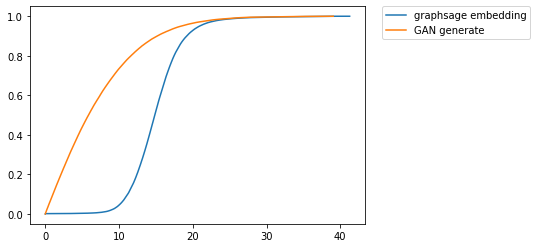

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.2546793
0.00023265221781499255
0.0021019575563211556
save: 2
mmd=0.256316,collapse=0.001339


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

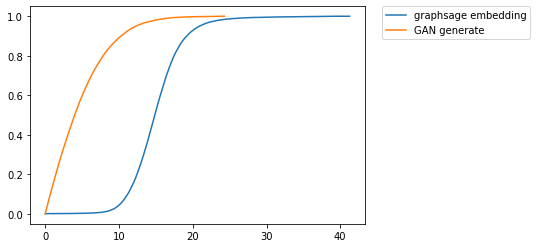

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3586835
0.00040584130914864797
0.0021019575563211556
save: 3
mmd=0.359974,collapse=0.001363


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

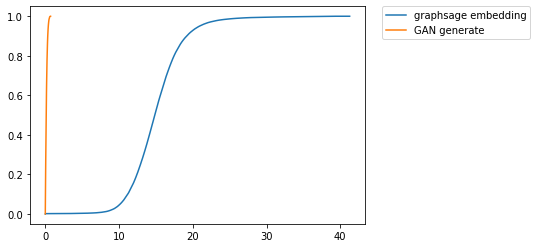

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [7.57346e-40 1.96406e-40 2.90924e-41 0.00000e+00 1.86450e-40]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.9961147
5.9833128952401133e-05
0.0021019575563211556
save: 4
mmd=0.998097,collapse=0.001342


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

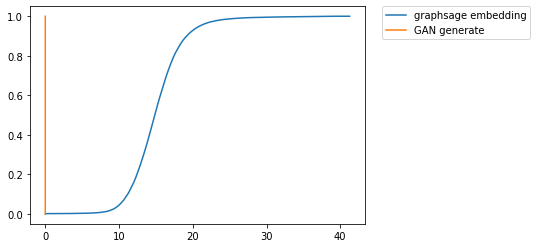

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930372339602e-05
0.0021019575563211556
save: 5
mmd=1.002004,collapse=1.000000
Using time:582.95
10000
10000
14


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

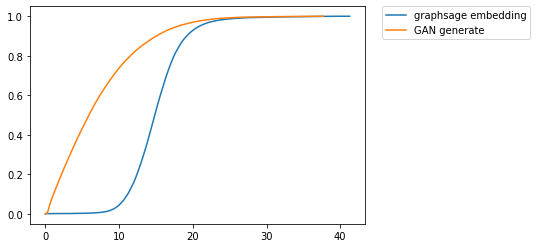

[[0.05927085 0.         0.         0.82241243 0.        ]
 [0.         0.         0.         0.90280807 0.        ]
 [0.         0.         0.         0.30879015 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.24747758
0.0006879014445266649
0.0021019575563211556
save: 0
mmd=0.248204,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

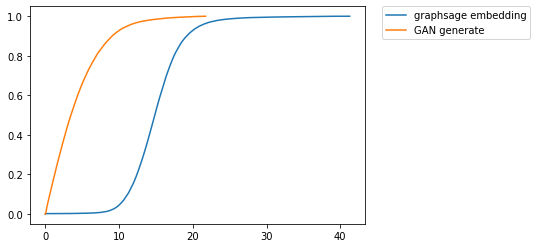

[[0.         0.         0.         0.4460399  0.05748348]
 [0.         0.         0.         0.67138755 0.08576991]
 [0.         0.         0.         0.844644   0.11664451]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.39890718
0.0007345103017299432
0.0021019575563211556
save: 1
mmd=0.399540,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

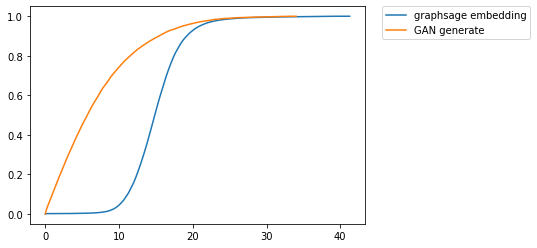

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.8557452e-01 0.0000000e+00]
 [5.6476521e-09 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.4365381e-08]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 3.6909488e-01 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.26444837
0.0007221346286790185
0.0021019575563211556
save: 2
mmd=0.265106,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

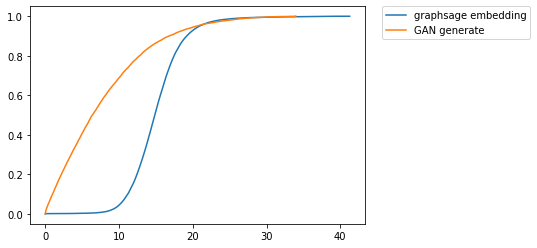

[[0.        0.        0.        2.3582075 0.       ]
 [0.        0.        0.        1.5852921 0.       ]
 [0.        0.        0.        2.0557723 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.24378426
0.00010348719541746486
0.0021019575563211556
save: 3
mmd=0.245679,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

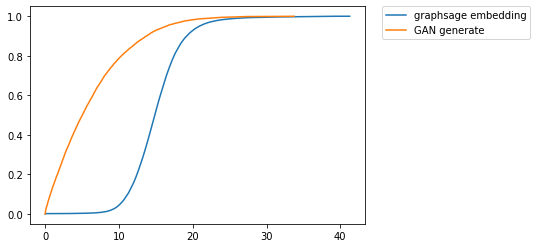

[[0.         0.         0.         0.00881211 0.        ]
 [0.         0.         0.         0.00215629 0.        ]
 [0.         0.         0.         0.03550672 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.30639666
0.000376682286792874
0.0021019575563211556
save: 4
mmd=0.307745,collapse=0.001335


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

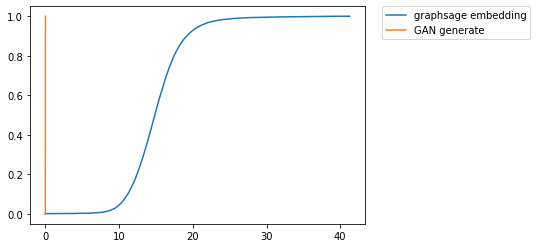

[[0.0000000e+00 0.0000000e+00 4.2468872e-40 4.7645211e-05 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6318436e-04 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 5.9469706e-40 1.7619874e-05 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.99999285
4.934928432152826e-05
0.0021019575563211556
save: 5
mmd=1.001996,collapse=0.008942


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

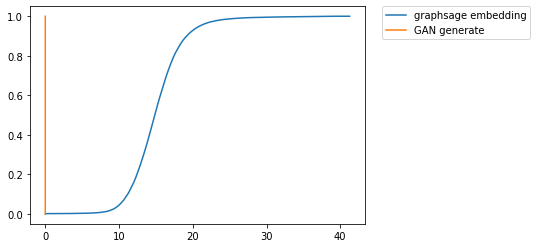

[[0.000000e+00 0.000000e+00 6.597537e-40 9.285103e-15 0.000000e+00]
 [0.000000e+00 0.000000e+00 6.597537e-40 9.285103e-15 0.000000e+00]
 [0.000000e+00 0.000000e+00 6.597537e-40 9.285103e-15 0.000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930372303883e-05
0.0021019575563211556
save: 6
mmd=1.002004,collapse=1.000000
Using time:673.84
10000
10000
15


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

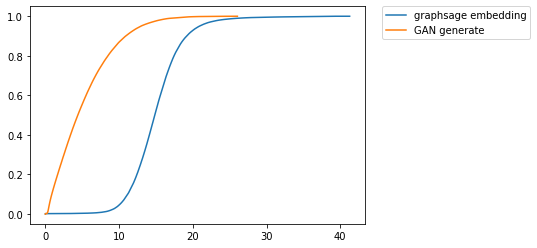

[[0.         0.         0.         0.24212323 0.        ]
 [0.         0.         0.         0.40057227 0.        ]
 [0.         0.         0.         0.7660875  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3211513
0.0008502236395655368
0.0021019575563211556
save: 0
mmd=0.321553,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

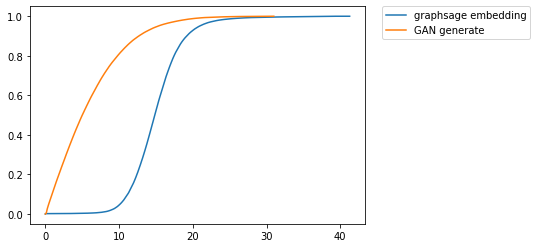

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 7.6958704e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 6.3672942e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 3.1778926e-04 1.1927569e-01 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.29017925
0.000704393225508241
0.0021019575563211556
save: 1
mmd=0.290872,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

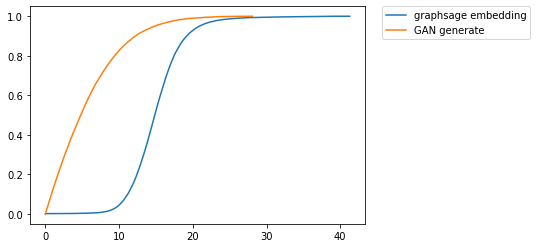

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3062233
0.00015272877697416549
0.0021019575563211556
save: 2
mmd=0.308020,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

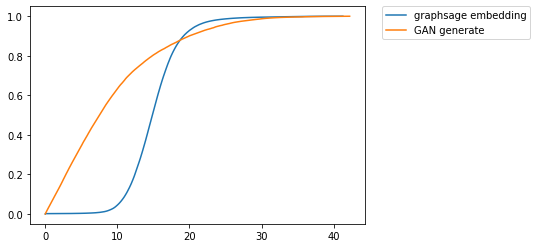

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.25265914 0.5689816  0.        ]
 [0.         0.         0.07563882 0.1701002  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.1940766
0.0002369134266478841
0.0021019575563211556
save: 3
mmd=0.195705,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

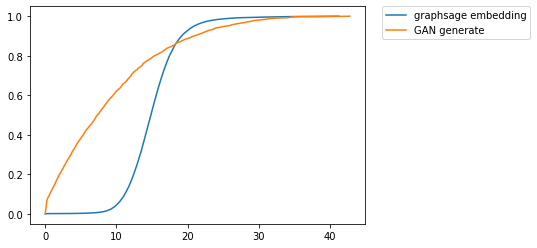

[[0.0000000e+00 0.0000000e+00 1.2546965e-04 4.4802783e-04 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.2897430e-05 2.2389344e-04 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.2014075e-04 7.8694086e-04 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.24681777
0.00025216773456354977
0.0021019575563211556
save: 4
mmd=0.248415,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

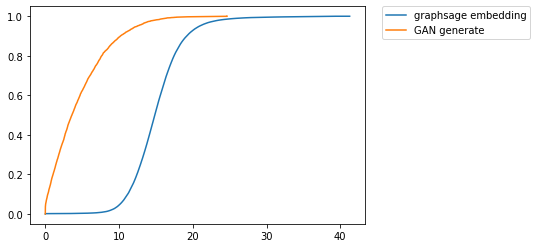

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.01247635e-14 3.28143749e-14
  0.00000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3996885
0.0002877279266517161
0.0021019575563211556
save: 5
mmd=0.401215,collapse=0.001609


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

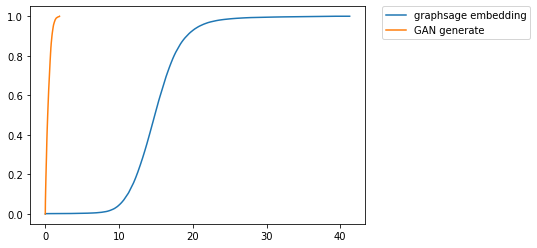

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.97219115
7.411409364698211e-05
0.0021019575563211556
save: 6
mmd=0.974145,collapse=0.003163


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

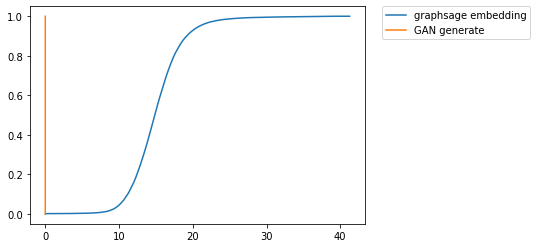

[[0.0000000e+00 0.0000000e+00 8.4173859e-33 2.3830766e-32 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 8.4173859e-33 2.3830766e-32 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 8.4173859e-33 2.3830766e-32 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930372317879e-05
0.0021019575563211556
save: 7
mmd=1.002004,collapse=1.000000


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Using time:777.06
10000
10000
16
Epoch:500/20000

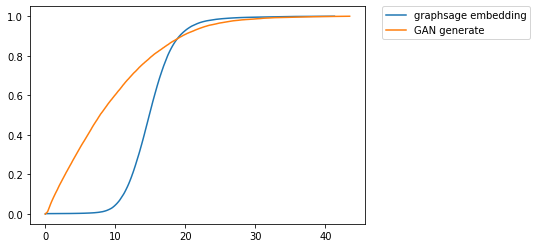

[[0.         0.         0.2852769  0.4440223  0.03418874]
 [0.         0.         0.23810233 0.39091158 0.03116715]
 [0.         0.         0.22447297 0.30476794 0.02909066]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.19360864
0.0005838435000920325
0.0021019575563211556
save: 0
mmd=0.194543,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

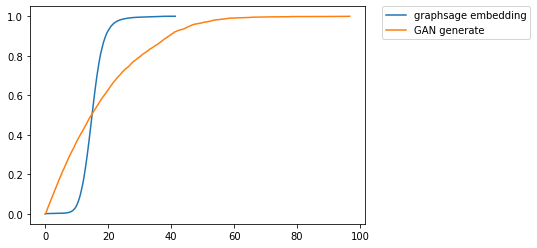

[[0.         0.         3.2423913  0.9283324  0.18452471]
 [0.         0.         1.2289162  0.3652552  0.06704737]
 [0.         0.         1.9100702  0.58341753 0.1071128 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.11000402
0.0002530097296376976
0.0021019575563211556
save: 1
mmd=0.111600,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

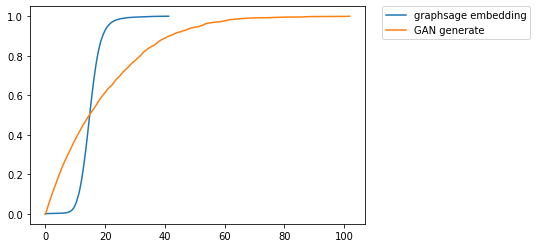

[[0.         0.         0.8202917  0.73038244 0.07987215]
 [0.         0.         0.05539474 0.3886335  0.01781397]
 [0.         0.         2.1081572  2.047506   0.21400669]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.12124275
0.00024426341360611023
0.0021019575563211556
save: 2
mmd=0.122856,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

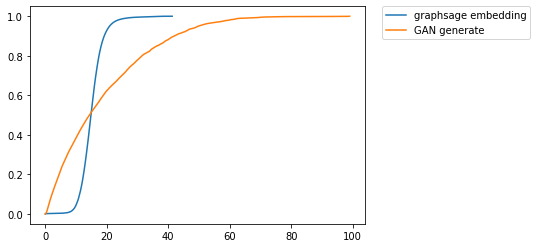

[[0.         0.         1.7160827  4.4094486  0.        ]
 [0.         0.         0.513121   1.2738041  0.        ]
 [0.         0.         0.19142279 0.2457717  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.1250216
0.0002472736221861314
0.0021019575563211556
save: 3
mmd=0.126629,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

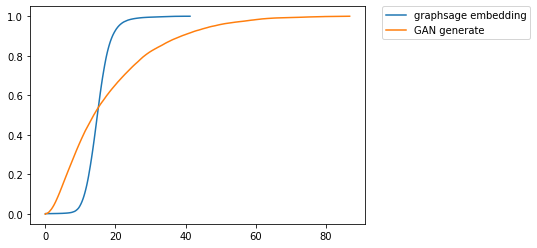

[[0.         0.         0.21485847 0.         0.        ]
 [0.         0.         0.02448729 1.0940789  0.        ]
 [0.         0.         0.23333207 0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.064372316
0.00035946666046126984
0.0021019575563211556
save: 4
mmd=0.065755,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

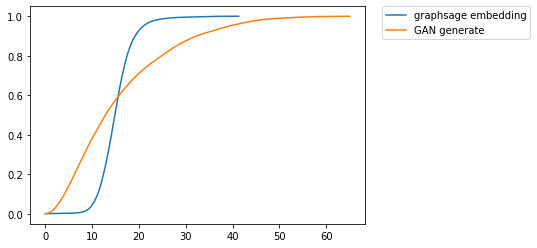

[[0.         0.         0.         2.715679   0.        ]
 [0.         0.         0.41103926 0.77894    0.        ]
 [0.         0.         1.072256   0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.05996634
0.0002174422903643982
0.0021019575563211556
save: 5
mmd=0.061633,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

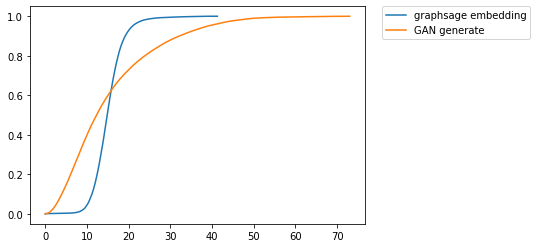

[[0.         0.         0.47829562 0.2805194  0.        ]
 [0.         0.         0.91457486 0.         0.        ]
 [0.         0.         0.         3.136175   0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.063338146
0.00019472078409760497
0.0021019575563211556
save: 6
mmd=0.065051,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

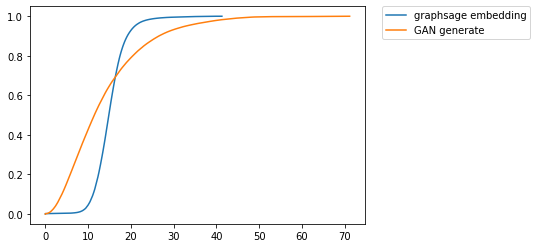

[[0.        0.        0.        0.0085716 0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.06465988
0.0002285321908851465
0.0021019575563211556
save: 7
mmd=0.066305,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/20000

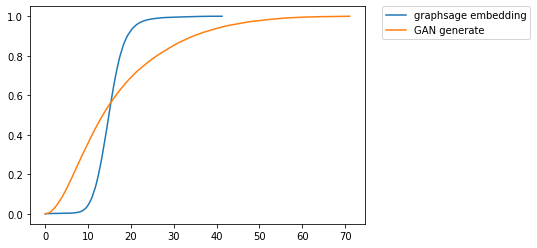

[[0.        0.        0.        0.1416248 0.       ]
 [0.        0.        0.        1.4938544 0.       ]
 [0.        0.        0.        2.7906668 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.055613402
0.00016556024899327384
0.0021019575563211556
save: 8
mmd=0.057384,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/20000

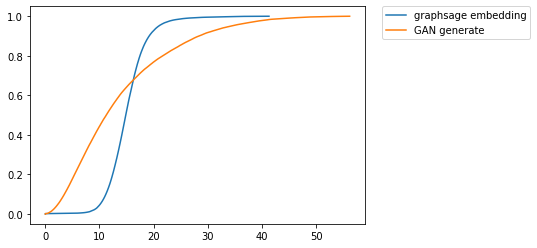

[[0.         0.         0.         0.40063685 0.        ]
 [0.         0.         0.         1.774971   0.        ]
 [0.         0.         0.5745911  0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.076863326
0.00020546508559669282
0.0021019575563211556
save: 9
mmd=0.078554,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5500/20000

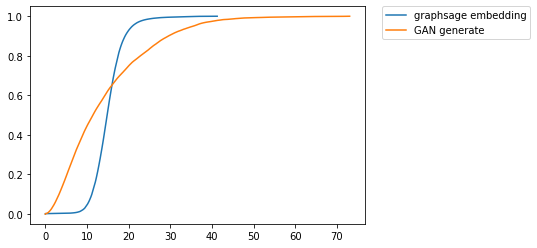

[[0.         0.         1.1531633  1.6353682  0.        ]
 [0.         0.         0.9847008  0.62982064 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.084544994
0.00021911630019632146
0.0021019575563211556
save: 10
mmd=0.086209,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6000/20000

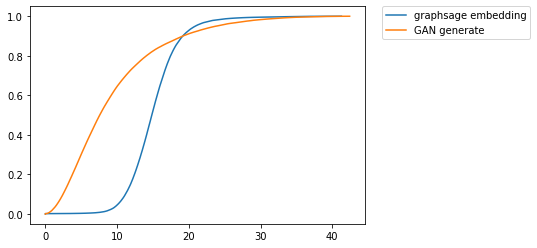

[[0.         0.         0.18178186 0.3854649  0.        ]
 [0.         0.         0.03532887 0.07208505 0.        ]
 [0.         0.         0.20941594 0.48416853 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.13482787
0.0003828551748747789
0.0021019575563211556
save: 11
mmd=0.136164,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6500/20000

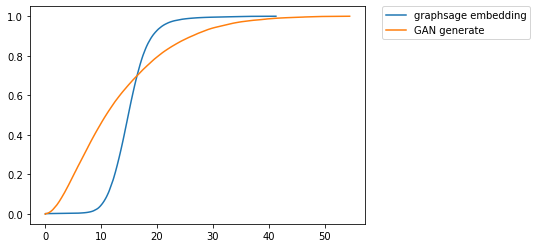

[[0.         0.         0.         0.675397   0.        ]
 [0.         0.         0.         0.38217887 0.        ]
 [0.         0.         0.31965995 0.04112555 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0854032
0.00025830532536922864
0.0021019575563211556
save: 12
mmd=0.086989,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7000/20000

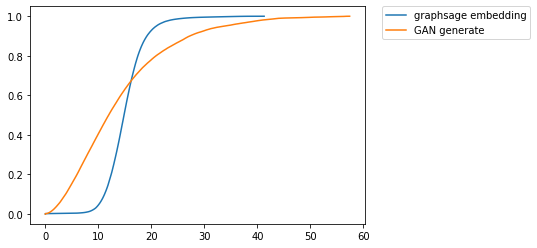

[[0.         0.         0.         0.02395754 0.        ]
 [0.         0.         0.         0.35616133 0.        ]
 [0.         0.         0.49850962 0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.06783961
0.00014269286575724403
0.0021019575563211556
save: 13
mmd=0.069656,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7500/20000

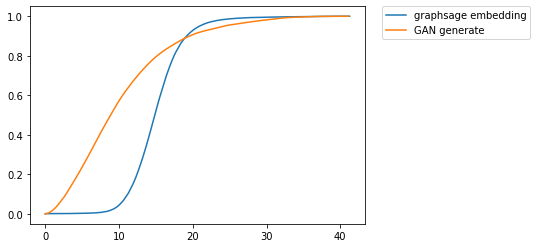

[[0.         0.         0.03066799 0.76044863 0.        ]
 [0.         0.         0.00433865 0.22724092 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.10871383
0.0002940716683761165
0.0021019575563211556
save: 14
mmd=0.110228,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:8000/20000

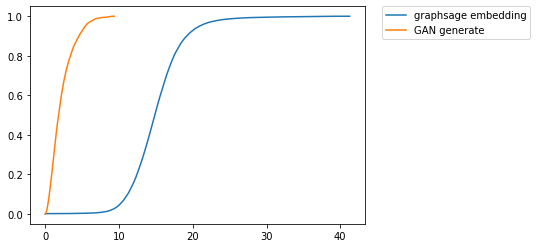

[[0.0000000e+00 0.0000000e+00 5.5216329e-09 3.2810310e-09 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.3229976e-09 1.3916441e-09 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.6357986
0.00022083391743229724
0.0021019575563211556
save: 15
mmd=0.637459,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:8500/20000

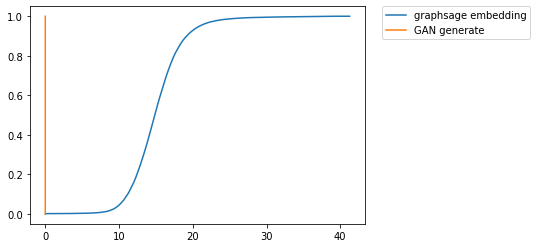

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9767041e-21 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0225388e-21 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9438302e-21 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930393900819e-05
0.0021019575563211556
save: 16
mmd=1.002004,collapse=1.000000
Using time:1644.00
10000
10000
17


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

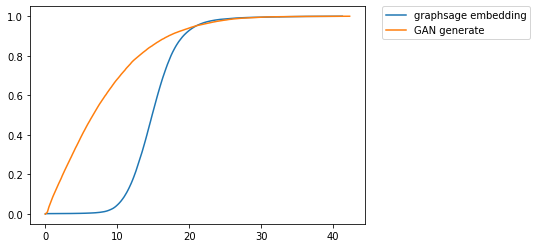

[[0.         0.         0.         0.7183094  0.05670238]
 [0.         0.         0.         0.86162007 0.06833575]
 [0.         0.         0.         0.52615654 0.0474454 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.22387753
0.0005600244139837273
0.0021019575563211556
save: 0
mmd=0.224859,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

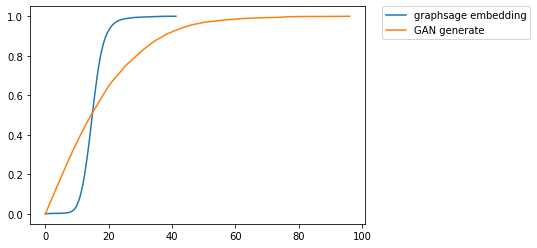

[[0.         0.         0.56045604 0.24620397 0.03589727]
 [0.01118365 0.         0.         0.01663313 0.07807782]
 [0.         0.         0.79938835 0.4169947  0.05300188]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.10443053
0.00027602435233409125
0.0021019575563211556
save: 1
mmd=0.105980,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

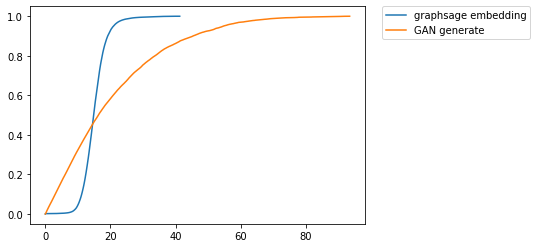

[[0.         0.         0.         1.2669777  0.11463656]
 [0.         0.         0.3498312  0.         0.        ]
 [0.         0.         0.2040793  0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.091974914
0.000233913419138289
0.0021019575563211556
save: 2
mmd=0.093609,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

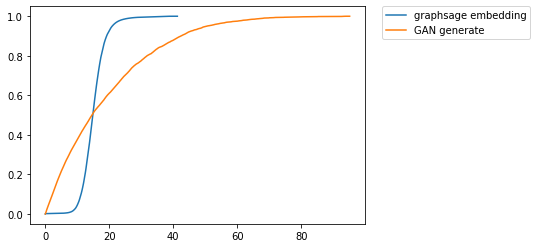

[[0.         0.         0.         1.2158095  0.        ]
 [0.         0.         0.         2.6645586  0.        ]
 [0.         0.         0.65746486 0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.12263265
0.00020330144450725815
0.0021019575563211556
save: 3
mmd=0.124328,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

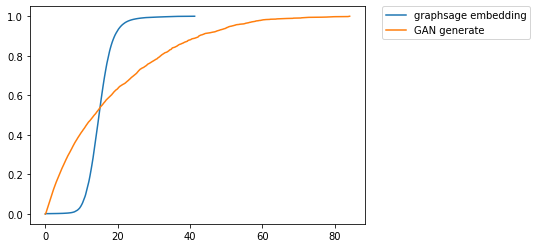

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.02032611 0.         0.        ]
 [0.         0.         0.         2.622273   0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.14471734
0.00018707470297849225
0.0021019575563211556
save: 4
mmd=0.146445,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

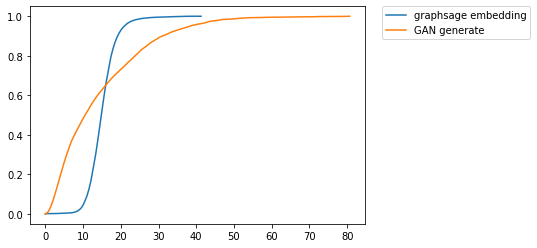

[[0.         0.         0.         1.5952679  0.        ]
 [0.         0.         0.         0.72820586 0.        ]
 [0.         0.         0.         0.5462537  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.12089813
0.0001782160791603515
0.0021019575563211556
save: 5
mmd=0.122644,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

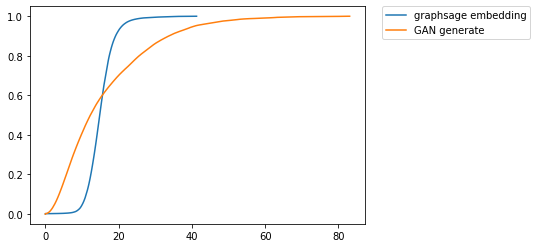

[[0.        0.        0.        1.0753602 0.       ]
 [0.        0.        0.        0.6787687 0.       ]
 [0.        0.        0.        3.7159839 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.068024665
0.00013138329046531296
0.0021019575563211556
save: 6
mmd=0.069864,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

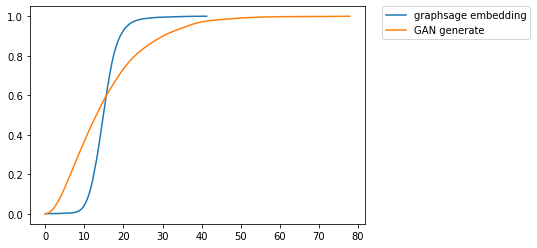

[[0.         0.         1.5509511  0.         0.        ]
 [0.         0.         0.17046164 0.         0.        ]
 [0.         0.         1.8432579  0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.05632049
0.00010873319594778032
0.0021019575563211556
save: 7
mmd=0.058205,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/20000

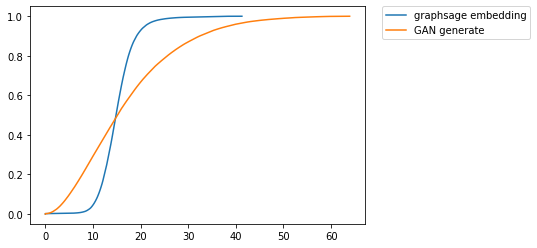

[[0.0000000e+00 0.0000000e+00 2.6988029e-03 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 3.2033669e-04 6.4177357e-02 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2950401e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.04020723
0.0001029649355641119
0.0021019575563211556
save: 8
mmd=0.042103,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/20000

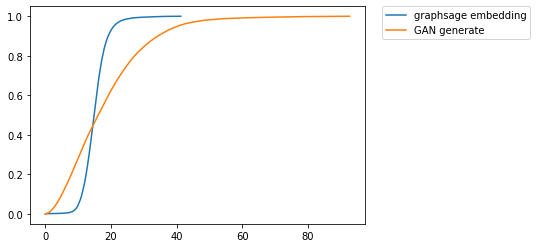

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.5942912e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 3.2304907e-12 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.1581387e-13 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.042272344
9.576324592570813e-05
0.0021019575563211556
save: 9
mmd=0.044183,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5500/20000

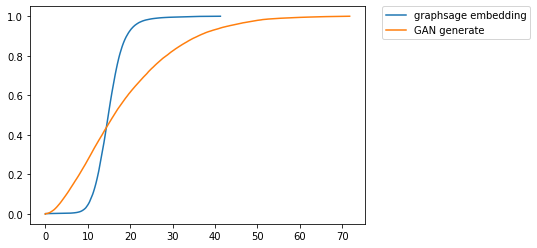

[[0.0000000e+00 0.0000000e+00 1.0061312e-20 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.4438137e-20 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 5.1074711e-21 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.042920206
9.289473513505573e-05
0.0021019575563211556
save: 10
mmd=0.044836,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6000/20000

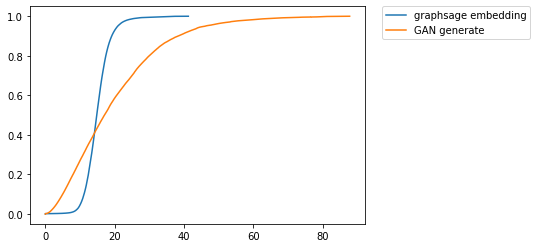

[[0.        0.        0.        0.2065076 0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.2970151 0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.04417535
6.61109876956202e-05
0.0021019575563211556
save: 11
mmd=0.046145,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6500/20000

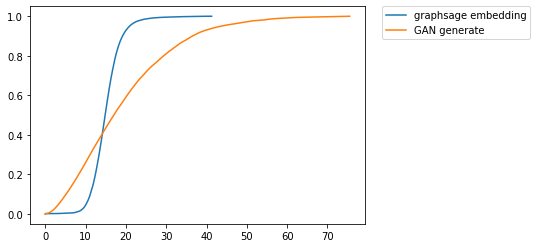

[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        1.3771071 0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.04203123
7.742752807054865e-05
0.0021019575563211556
save: 12
mmd=0.043978,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7000/20000

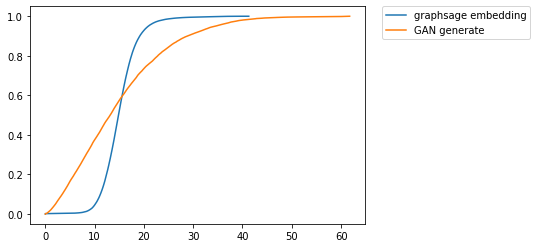

[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.8011495 0.        0.       ]
 [0.        0.        4.6790466 0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.07987636
0.00014954110260980514
0.0021019575563211556
save: 13
mmd=0.081679,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7500/20000

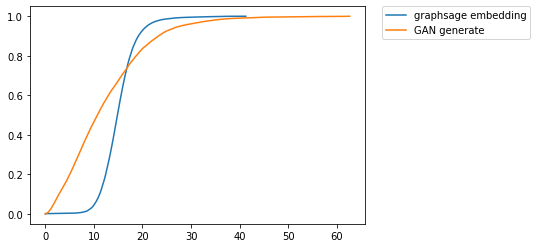

[[0.         0.         0.         0.9924237  0.06176171]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.8052394  0.6045236  0.03701711]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.10000454
0.0001534213108179742
0.0021019575563211556
save: 14
mmd=0.101800,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:8000/20000

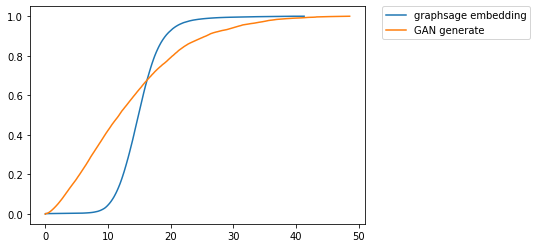

[[0.         0.         0.         2.9340892  0.6332109 ]
 [0.         0.         0.         1.2571455  0.15226911]
 [0.         0.         0.         2.5104685  1.6902895 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.08644277
8.508700296629889e-05
0.0021019575563211556
save: 15
mmd=0.088375,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:8500/20000

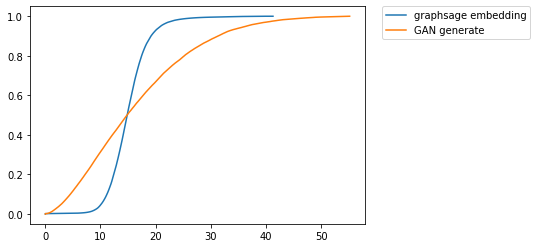

[[0.         0.         0.         0.11855975 0.01302391]
 [0.         0.         3.592883   0.         0.        ]
 [0.         0.         4.412509   0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.052464288
5.729254111067682e-05
0.0021019575563211556
save: 16
mmd=0.054452,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:9000/20000

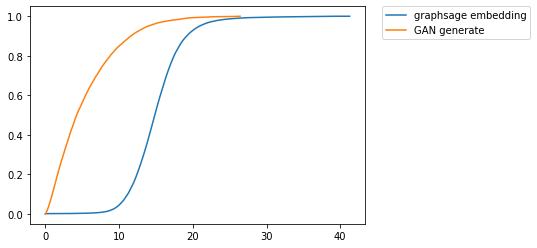

[[0.         0.         0.02475327 0.17899863 0.00813439]
 [0.         0.         0.         0.0435841  0.        ]
 [0.         0.         0.         0.03343302 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.32732785
0.0002486791259691654
0.0021019575563211556
save: 17
mmd=0.328932,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:9500/20000

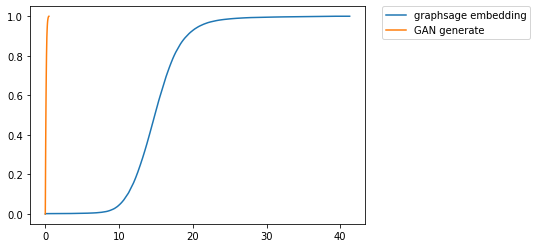

[[0.000000e+00 0.000000e+00 1.428064e-11 1.143028e-11 9.328542e-13]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.9982455
5.720475656503686e-05
0.0021019575563211556
save: 18
mmd=1.000233,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:10000/20000

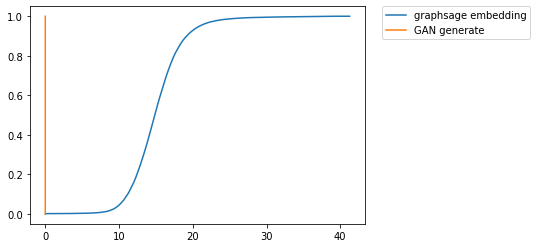

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.89993043614638e-05
0.0021019575563211556
save: 19
mmd=1.002004,collapse=1.000000
Using time:1934.48
10000
10000
18


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

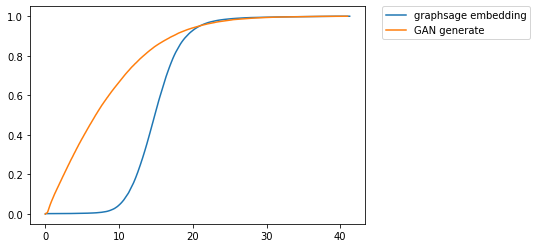

[[0.         0.         0.00056904 0.00036088 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.21770465
0.0005499157873941713
0.0021019575563211556
save: 0
mmd=0.218707,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

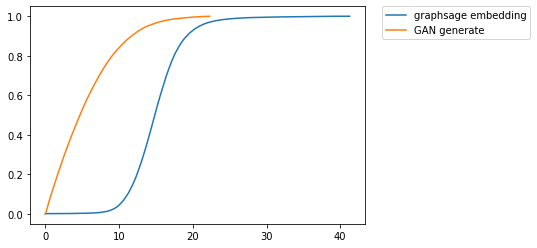

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.31143224
0.0004506026984999064
0.0021019575563211556
save: 1
mmd=0.312633,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

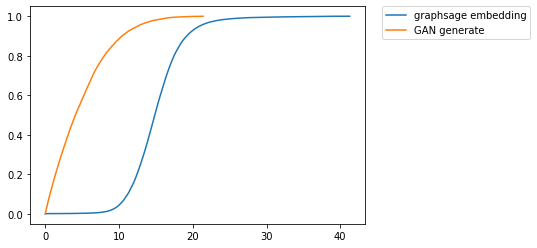

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 5.816713e-21 6.916749e-21 0.000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.35614505
0.00037457524422629434
0.0021019575563211556
save: 2
mmd=0.357498,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

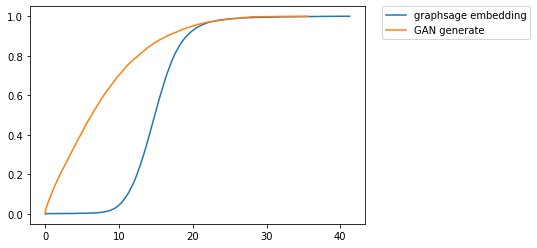

[[0.         0.         0.         0.13544632 0.        ]
 [0.         0.         0.         0.11402735 0.        ]
 [0.         0.         0.         0.1908834  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.2540322
0.00031598362465432196
0.0021019575563211556
save: 3
mmd=0.255502,collapse=0.001388


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

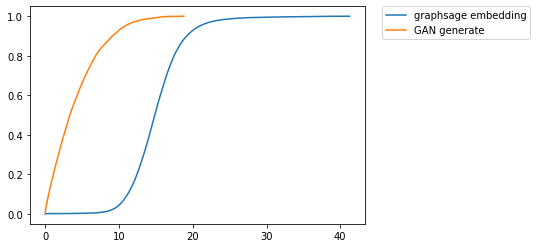

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 4.358355e-07 4.559464e-15 0.000000e+00 0.000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.41682494
0.000217474482458059
0.0021019575563211556
save: 4
mmd=0.418492,collapse=0.001574


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

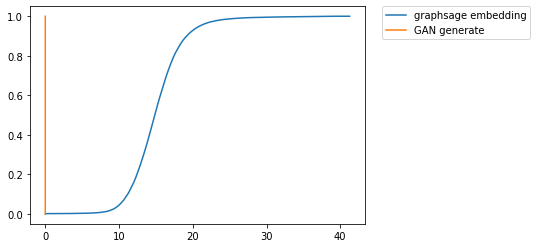

[[0.000000e+00 0.000000e+00 9.084639e-25 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.9005806144034647e-05
0.0021019575563211556
save: 5
mmd=1.002004,collapse=0.650114
Using time:585.67
10000
10000
19


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

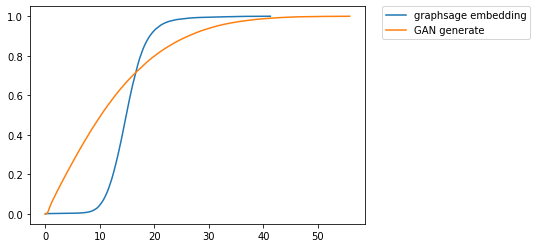

[[0.         0.         1.4322394  0.91549325 0.        ]
 [0.         0.         1.6867503  1.1160545  0.        ]
 [0.         0.         0.5407522  0.3178532  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.14557463
0.00037881450769357565
0.0021019575563211556
save: 0
mmd=0.146919,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

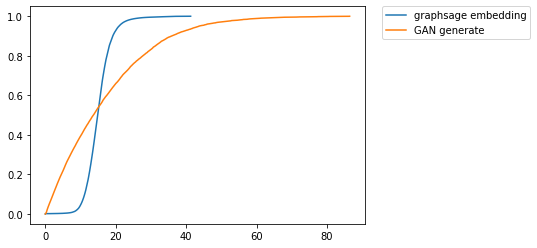

[[0.         0.         0.         0.         0.00288413]
 [0.         0.         0.7807982  0.4655985  0.1004185 ]
 [0.         0.         0.51456594 0.2890409  0.06966826]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.12377359
0.0003318357151626282
0.0021019575563211556
save: 1
mmd=0.125212,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

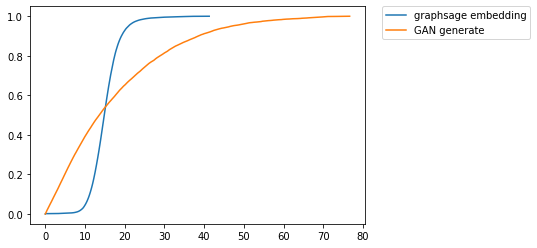

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.64306355 3.6593792  0.13848668]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.113481745
0.00020568163417346213
0.0021019575563211556
save: 2
mmd=0.115172,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

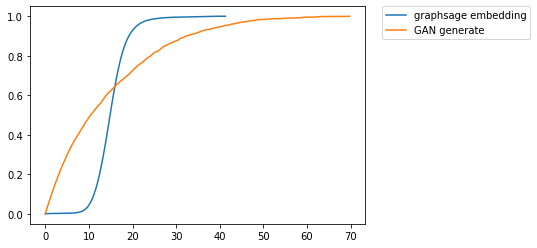

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.04611767 0.0092034  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.17808774
0.00022296662815946466
0.0021019575563211556
save: 3
mmd=0.179744,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

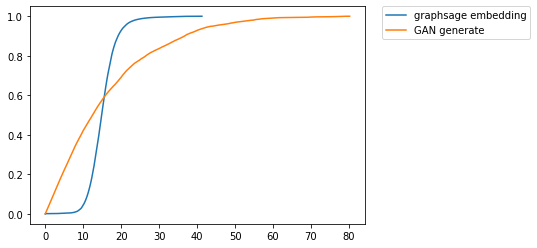

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.15564805 0.10783336 0.        ]
 [0.         0.         0.2812791  0.2759267  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.12547469
0.00022780981256709357
0.0021019575563211556
save: 4
mmd=0.127121,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

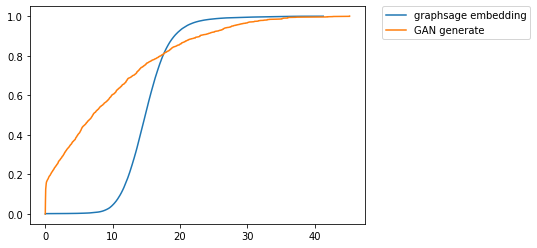

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.1752737e-06 9.0416445e-04 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.30236956
0.0002633330252788682
0.0021019575563211556
save: 5
mmd=0.303945,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

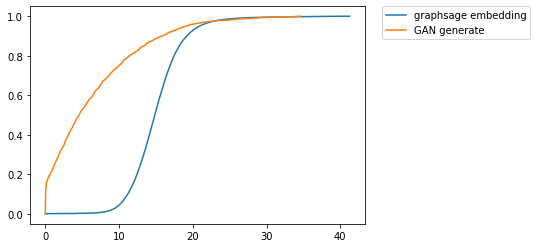

[[4.3822195e-23 0.0000000e+00 6.8650390e-16 1.8549568e-13 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.36825183
0.0003727809644929459
0.0021019575563211556
save: 6
mmd=0.369608,collapse=0.001370


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/20000

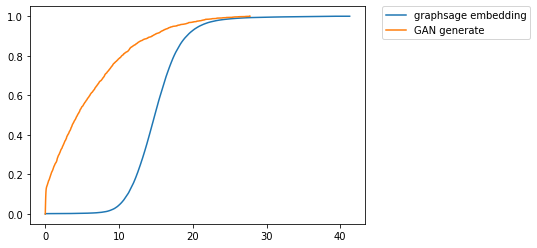

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.1937421e-24 8.3624497e-22 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.3720151
0.00013983799886170176
0.0021019575563211556
save: 7
mmd=0.373837,collapse=0.001388


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/20000

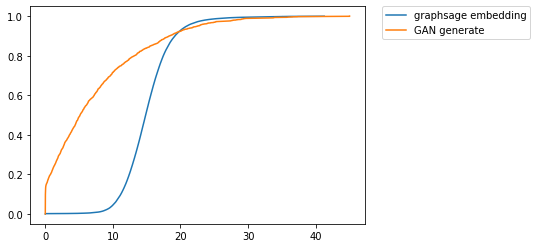

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.34473124
0.0001522047857397199
0.0021019575563211556
save: 8
mmd=0.346529,collapse=0.002816


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/20000

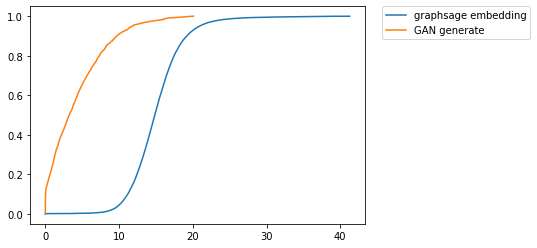

[[0.000000e+00 0.000000e+00 2.365037e-39 8.376962e-42 0.000000e+00]
 [0.000000e+00 0.000000e+00 3.603289e-39 4.990753e-40 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.4459157
0.00019725628650204982
0.0021019575563211556
save: 9
mmd=0.447623,collapse=0.004174


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5500/20000

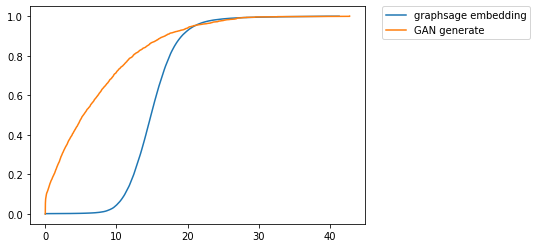

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7459922e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0302767e-39 6.6505363e-03 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.2908695e-01 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.32405493
0.00019803691374342049
0.0021019575563211556
save: 10
mmd=0.325761,collapse=0.002447


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6000/20000

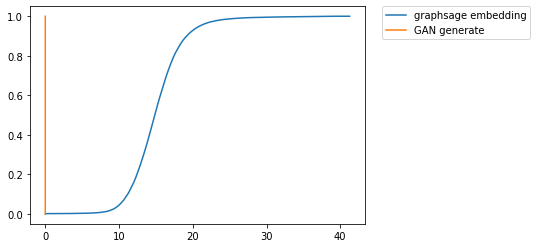

[[0.0000000e+00 0.0000000e+00 6.7573555e-40 2.0593316e-07 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.7566969e-40 2.0644255e-07 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.7535159e-40 2.0915731e-07 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.8999330893762677e-05
0.0021019575563211556
save: 11
mmd=1.002004,collapse=1.000000
Using time:1168.54
10000
10000
20


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

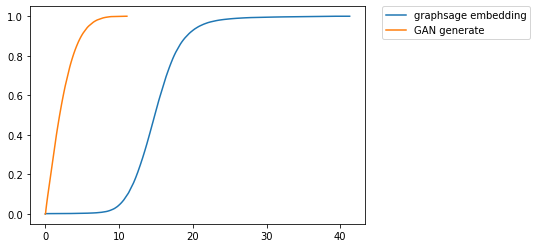

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.6088278
0.00010971890675645358
0.0021019575563211556
save: 0
mmd=0.610710,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

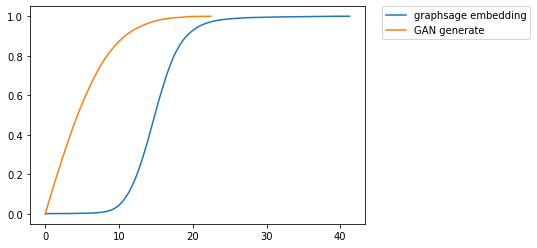

[[0.         0.         0.         0.06283832 0.01481616]
 [0.         0.         0.         0.5400639  0.1277321 ]
 [0.         0.         0.         0.01747624 0.00409763]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.32723847
0.0005205073043242579
0.0021019575563211556
save: 1
mmd=0.328299,collapse=0.001339


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

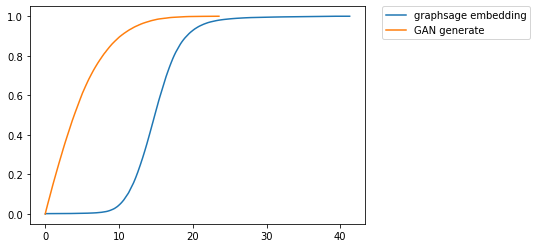

[[0.         0.         0.         0.15219648 0.        ]
 [0.         0.         0.         0.2068229  0.        ]
 [0.         0.         0.         0.5483156  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.36155418
0.0005050228948789017
0.0021019575563211556
save: 2
mmd=0.362646,collapse=0.001353


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

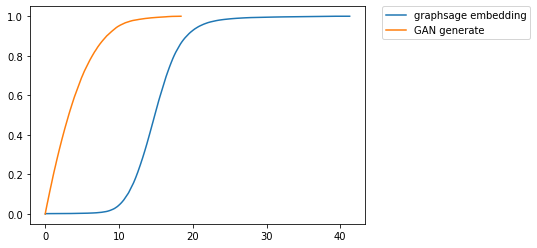

[[0.         0.         0.         0.19914761 0.        ]
 [0.         0.         0.         0.5916548  0.        ]
 [0.         0.         0.         0.02474943 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.43147182
0.0003888936812865463
0.0021019575563211556
save: 3
mmd=0.432796,collapse=0.001451


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

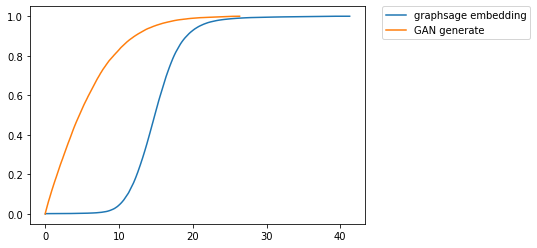

[[0.         0.         0.18044929 0.5218141  0.        ]
 [0.         0.         0.24590872 0.7113623  0.        ]
 [0.         0.         0.08167365 0.23580837 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.31933263
0.0005237970292344127
0.0021019575563211556
save: 4
mmd=0.320387,collapse=0.001395


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

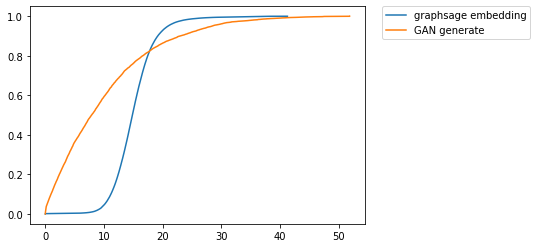

[[6.5674831e-15 3.3557136e-11 2.1259717e-05 8.8791507e-09 8.7097344e-36]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.22192861
6.815005586171085e-05
0.0021019575563211556
save: 5
mmd=0.223894,collapse=0.001377


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

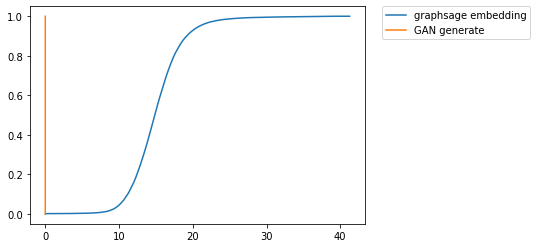

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
1.0
4.899930381247796e-05
0.0021019575563211556
save: 6
mmd=1.002004,collapse=1.000000
Using time:681.23
10000
10000
21


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:500/20000

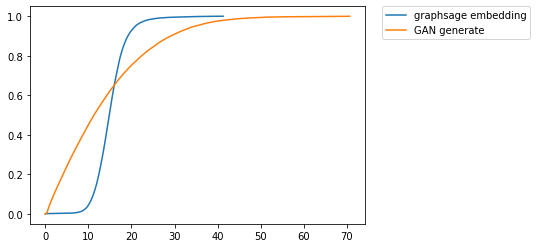

[[0.         0.         0.19855297 0.         0.        ]
 [0.         0.         0.74056107 0.03998428 0.        ]
 [0.         0.         0.736874   0.07708958 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.13588239
0.0003510137896151909
0.0021019575563211556
save: 0
mmd=0.137282,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1000/20000

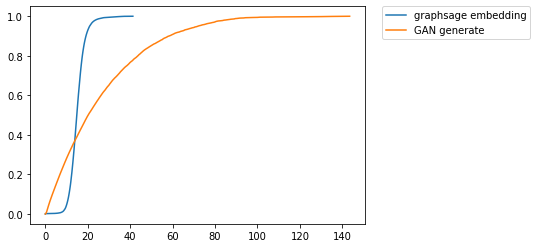

[[0.        0.        3.4838934 0.        0.       ]
 [0.        0.        2.079559  0.        0.       ]
 [0.        0.        5.0250797 0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.08127805
0.0002365213896234062
0.0021019575563211556
save: 1
mmd=0.082907,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1500/20000

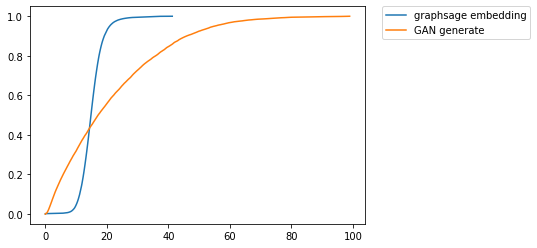

[[0.         0.         0.5461355  1.2442415  0.        ]
 [0.         0.         0.76813227 1.7442281  0.        ]
 [0.         0.         2.1153414  3.5712662  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.09148804
0.00043947673927745615
0.0021019575563211556
save: 2
mmd=0.092711,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2000/20000

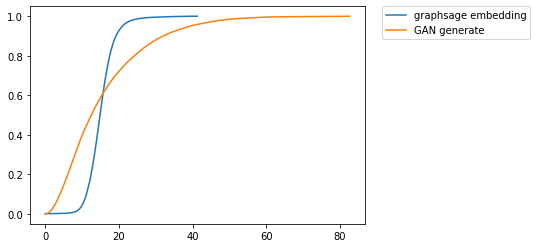

[[0.         0.         0.033701   2.3761928  0.4757028 ]
 [0.         0.         0.5025467  1.2088511  0.18566132]
 [0.         0.         0.19284962 0.09691682 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.062349815
0.00030619059748881924
0.0021019575563211556
save: 3
mmd=0.063839,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:2500/20000

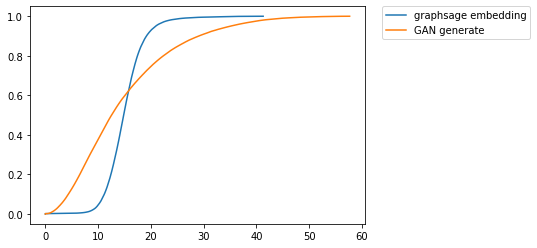

[[0.         0.         0.18377951 0.11402371 0.        ]
 [0.         0.         0.8375983  1.8780231  0.        ]
 [0.         0.         0.65607035 0.30582672 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.05268613
0.00019270580564227402
0.0021019575563211556
save: 4
mmd=0.054403,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3000/20000

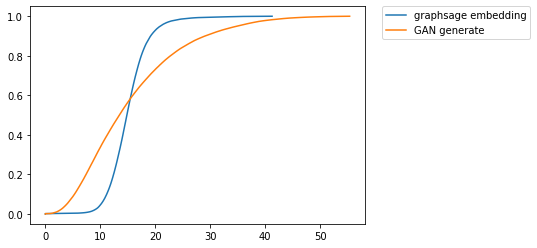

[[0.         0.         0.03947235 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.48112446 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.031751238
0.0001751663361495372
0.0021019575563211556
save: 5
mmd=0.033503,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:3500/20000

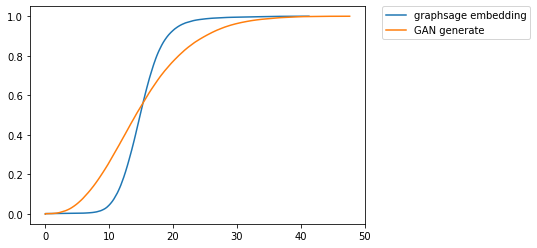

[[0.         0.         1.4788449  1.6609017  0.19589125]
 [0.         0.         3.2055058  2.2481768  0.41170236]
 [0.         0.         0.7079142  1.2234492  0.11724048]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.018733868
0.00014311739994712021
0.0021019575563211556
save: 6
mmd=0.020550,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4000/50000

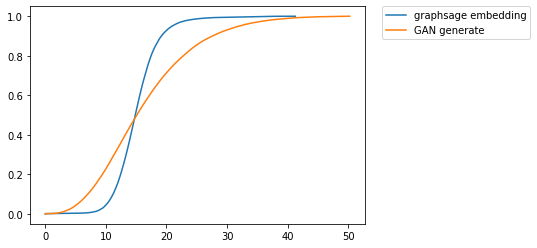

[[0.        0.        0.        2.9449744 0.       ]
 [0.        0.        0.        2.5811648 0.       ]
 [0.        0.        0.        5.2295794 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.015386176
9.742206578609839e-05
0.0021019575563211556
save: 7
mmd=0.017293,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:4500/50000

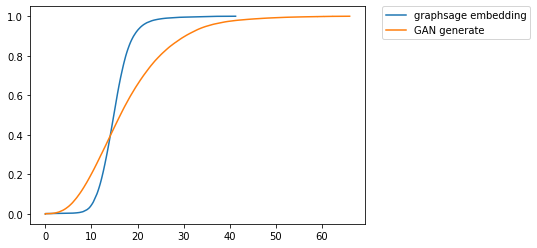

[[0.        0.        0.        2.8772054 0.       ]
 [0.        0.        0.        4.7275763 0.       ]
 [0.        0.        1.7899872 0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.013623424
0.00010544289319254933
0.0021019575563211556
save: 8
mmd=0.015514,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5000/50000

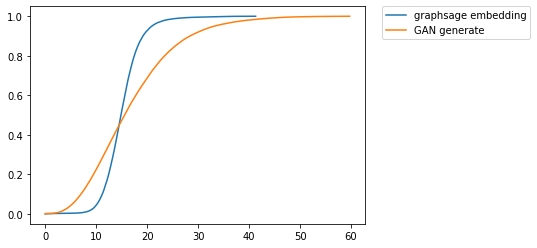

[[0.         0.         1.4661036  0.         0.05270304]
 [0.         0.         3.056096   0.09148335 0.46689916]
 [0.         0.         2.086377   2.7458441  0.44359952]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.015548487
0.00011155913015076608
0.0021019575563211556
save: 9
mmd=0.017427,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:5500/50000

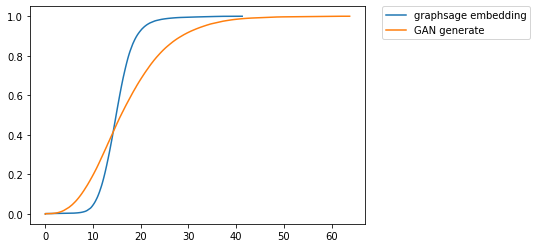

[[0.         0.         0.         0.         0.18980365]
 [0.         0.         0.8304619  0.5606833  0.06314054]
 [0.         0.         2.6819222  0.24127224 0.42165446]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.012382312
0.00010647375929425493
0.0021019575563211556
save: 10
mmd=0.014271,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6000/50000

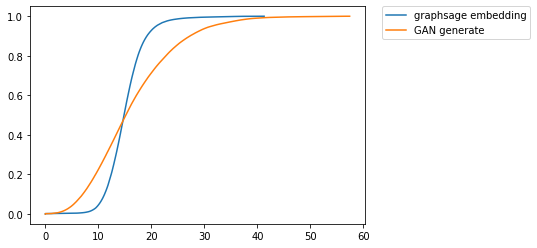

[[0.         0.         0.5774194  1.3753587  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.14050059]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.014848737
0.00027779249644794364
0.0021019575563211556
save: 11
mmd=0.016395,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:6500/50000

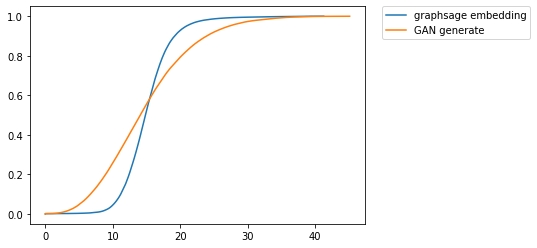

[[0.         0.         0.         0.         0.        ]
 [0.         0.         1.8130035  0.         0.09301472]
 [0.         0.         0.         1.7911932  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.01695742
0.00020603791402468963
0.0021019575563211556
save: 12
mmd=0.018647,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7000/50000

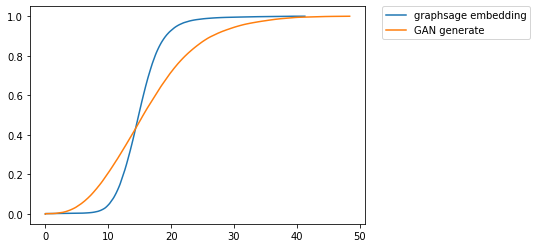

[[0.         0.         0.         0.31189364 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.5947721  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.013236482
6.085727481566847e-05
0.0021019575563211556
save: 13
mmd=0.015217,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:7500/50000

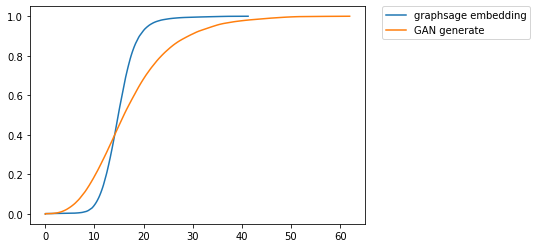

[[0.        0.        6.8374677 0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        7.548894  0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.012152015
6.11831029656085e-05
0.0021019575563211556
save: 14
mmd=0.014132,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:8000/50000

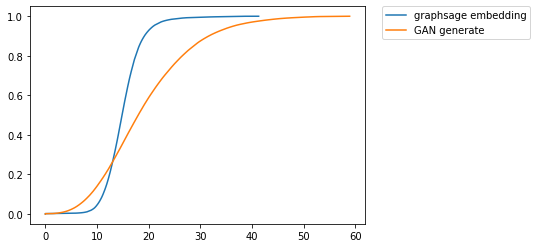

[[0.         0.         1.3678602  0.         2.3263214 ]
 [0.         0.         0.         3.1518822  0.12777214]
 [0.         0.         1.9746075  0.         0.5782778 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.008660848
4.072945416485813e-05
0.0021019575563211556
save: 15
mmd=0.010681,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:8500/50000

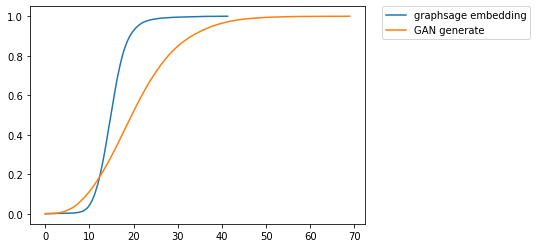

[[0.        0.        0.        3.0130064 0.       ]
 [0.        0.        1.8161122 2.2015333 1.7121395]
 [0.        0.        5.4595866 1.2461152 2.6066003]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.007082405
5.080463838174828e-05
0.0021019575563211556
save: 16
mmd=0.009083,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:9000/50000

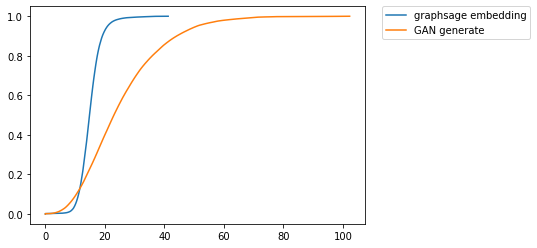

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.54698896 0.86475563]
 [0.         0.         0.28340456 3.3933992  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0061021307
5.1643433973441296e-05
0.0021019575563211556
save: 17
mmd=0.008101,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:9500/50000

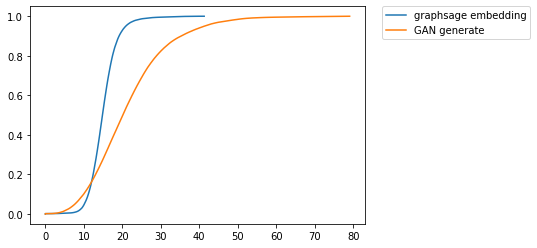

[[0.         0.         0.13949013 0.2090177  0.        ]
 [0.         0.         0.         2.126429   0.        ]
 [0.         0.         0.         2.0578897  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0058997786
2.8434657509840596e-05
0.0021019575563211556
save: 18
mmd=0.007945,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:10000/50000

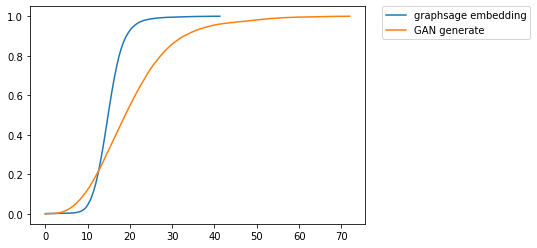

[[0.0000000e+00 0.0000000e+00 2.6105827e-01 4.5463613e-01 4.5512814e-02]
 [0.0000000e+00 0.0000000e+00 1.2798367e+00 2.7885723e-01 1.0054929e-03]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7843902e+00 2.4346356e-01]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0067266333
3.6786916348523865e-05
0.0021019575563211556
save: 19
mmd=0.008755,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:10500/50000

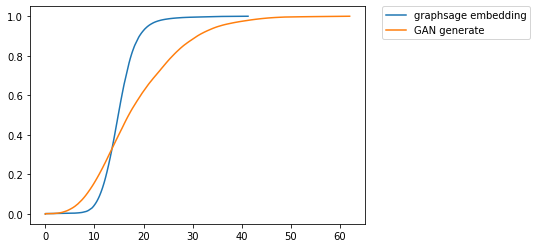

[[0.         0.         4.6185064  1.4256725  0.4094354 ]
 [0.         0.         0.         0.811692   0.36560482]
 [0.         0.         1.4062831  0.37502033 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.008327864
8.128702842163658e-05
0.0021019575563211556
save: 20
mmd=0.010267,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:11000/50000

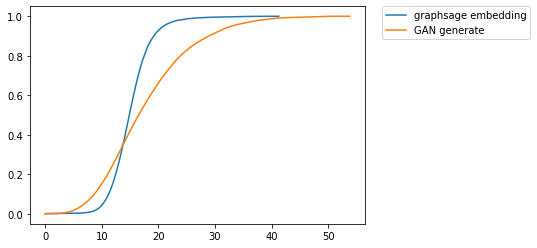

[[0.         0.         2.9086792  4.680764   1.1234486 ]
 [0.         0.         1.0572561  1.7721845  0.05277368]
 [0.         0.         0.23259984 1.8362185  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.006775967
0.00010644562190432585
0.0021019575563211556
save: 21
mmd=0.008665,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:11500/50000

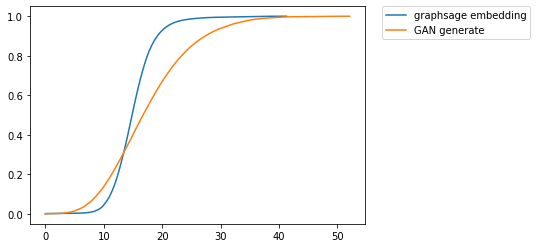

[[0.         0.         0.         0.6822753  0.        ]
 [0.         0.         0.         8.505966   0.        ]
 [0.         0.         0.54399824 5.0466356  0.04710348]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.005771461
8.016437867149711e-05
0.0021019575563211556
save: 22
mmd=0.007713,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:12000/50000

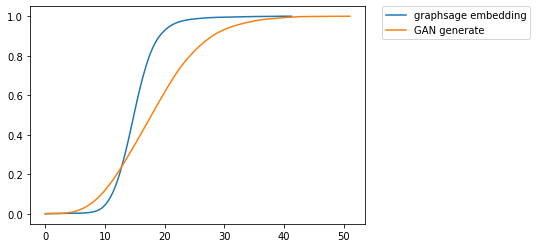

[[0.         0.         0.         5.280708   0.35699227]
 [0.         0.         0.         3.1949685  1.0748318 ]
 [0.         0.         0.         0.         0.03354819]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0050502014
0.0001322450058458174
0.0021019575563211556
save: 23
mmd=0.006888,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:12500/50000

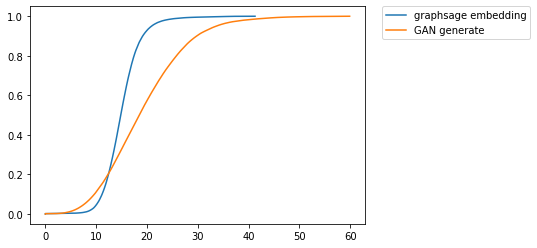

[[0.         0.         0.         5.29941    0.38230324]
 [0.         0.         0.1704795  3.1368206  0.        ]
 [0.         0.         0.9654011  5.5250354  0.52439654]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0049188575
0.000120385370774254
0.0021019575563211556
save: 24
mmd=0.006780,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:13000/50000

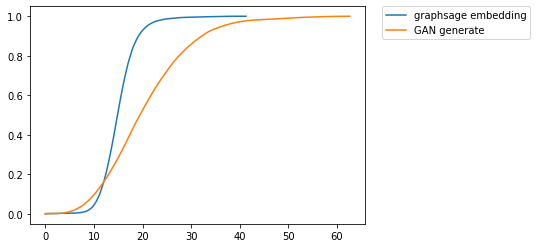

[[0.         0.         1.3878489  1.1370538  0.5364168 ]
 [0.         0.         1.3941056  1.7228357  0.91607696]
 [0.         0.         2.0756152  3.3609617  0.39880136]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.004378767
6.141480668055183e-05
0.0021019575563211556
save: 25
mmd=0.006358,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:13500/50000

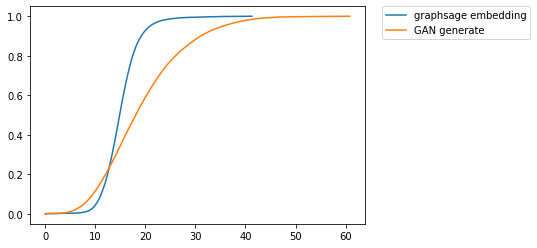

[[0.         0.         0.71050835 1.3304011  0.        ]
 [0.         0.         1.6283063  1.0444417  0.        ]
 [0.         0.         0.27894014 0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0046612583
5.7007791191815255e-05
0.0021019575563211556
save: 26
mmd=0.006649,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:14000/50000

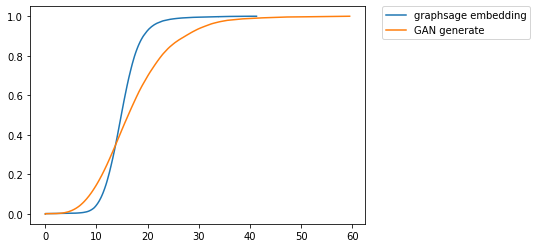

[[0.         0.         0.76847804 1.9760303  0.3395112 ]
 [0.         0.         0.         0.52824444 0.        ]
 [0.         0.         0.7739692  1.0335523  0.36332074]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0057472647
0.0001492212401248924
0.0021019575563211556
save: 27
mmd=0.007551,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:14500/50000

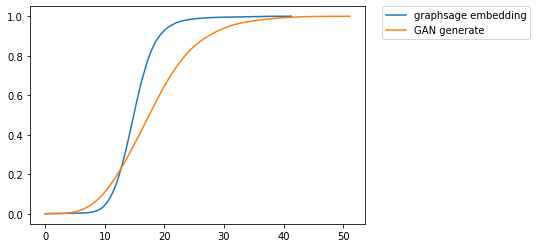

[[0.        0.        0.370247  4.906746  0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        2.0933516 1.0024205 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0042900178
5.0900222405250904e-05
0.0021019575563211556
save: 28
mmd=0.006290,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:15000/50000

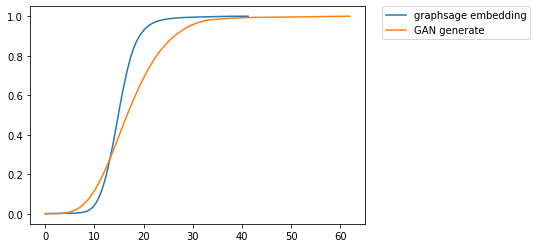

[[0.         0.         0.5456807  0.         0.12251724]
 [0.         0.         0.60431224 0.         0.        ]
 [0.         0.         0.         0.21863891 0.2881327 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.004080848
6.781131675492198e-05
0.0021019575563211556
save: 29
mmd=0.006047,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:15500/50000

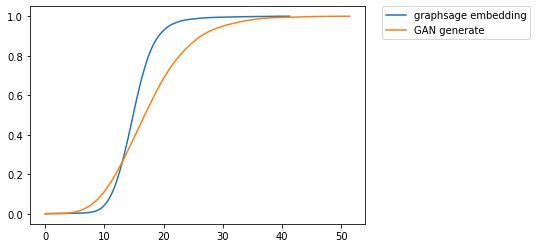

[[0.         0.         0.         5.501266   0.61463755]
 [0.         0.         0.         8.367635   1.6004082 ]
 [0.         0.         0.         4.431751   1.0805371 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.003949589
6.062354134424205e-05
0.0021019575563211556
save: 30
mmd=0.005930,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:16000/50000

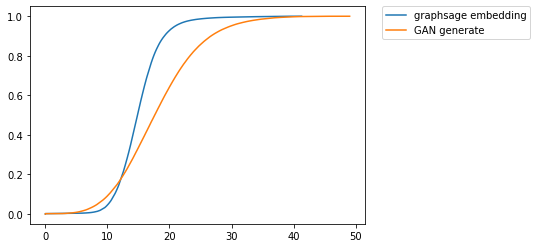

[[0.         0.         0.         0.42115104 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.0730838  1.9882892  0.09832168]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.003457387
2.3537330541550916e-05
0.0021019575563211556
save: 31
mmd=0.005512,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:16500/50000

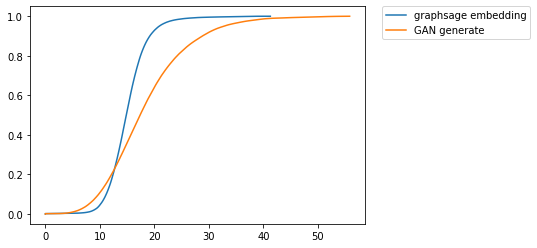

[[0.         0.         0.         1.4625144  0.        ]
 [0.         0.         0.4877518  0.         0.        ]
 [0.         0.         0.         0.23070918 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0038257518
5.155630156889067e-05
0.0021019575563211556
save: 32
mmd=0.005825,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:17000/50000

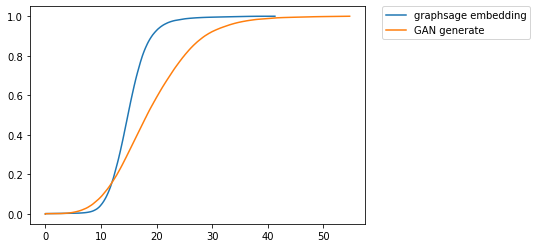

[[0.         0.         0.         0.         0.        ]
 [0.         0.         1.71525    3.6133552  0.        ]
 [0.         0.         0.17943457 1.7329469  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0033535315
2.26378118655664e-05
0.0021019575563211556
save: 33
mmd=0.005410,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:17500/50000

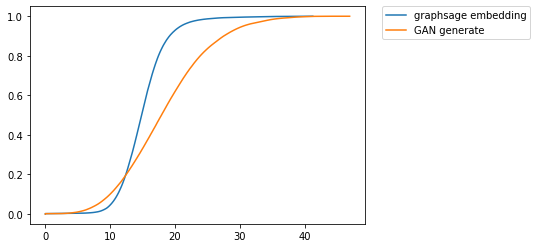

[[0.         0.         0.91594297 0.         2.534602  ]
 [0.         0.         0.         0.08998524 0.        ]
 [0.         0.         0.         0.         0.55525064]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0039575165
6.664419415705474e-05
0.0021019575563211556
save: 34
mmd=0.005926,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:18000/50000

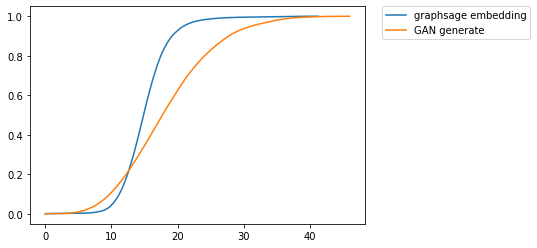

[[0.         0.         0.         2.0759146  0.        ]
 [0.         0.         0.         0.07567319 0.        ]
 [0.         0.         0.         3.835814   0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.004157991
8.291332911546482e-05
0.0021019575563211556
save: 35
mmd=0.006094,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:18500/50000

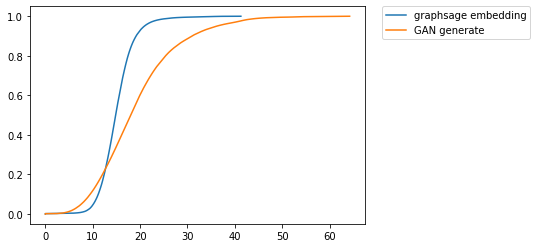

[[0.         0.         0.10466571 1.2313707  0.10022427]
 [0.         0.         0.         1.7035326  0.        ]
 [0.         0.         0.         2.1909926  0.24016558]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0046020616
8.180318152606442e-05
0.0021019575563211556
save: 36
mmd=0.006540,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:19000/50000

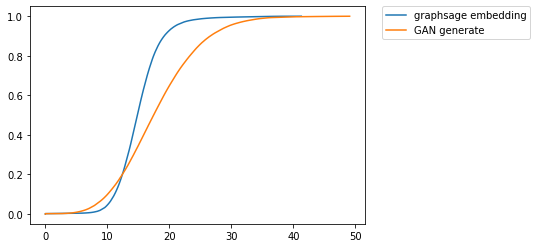

[[0.         0.         1.5766298  1.5431728  0.1006003 ]
 [0.         0.         0.         0.83535177 0.        ]
 [0.         0.         0.         0.6528522  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0035222908
6.290070042240635e-05
0.0021019575563211556
save: 37
mmd=0.005498,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:19500/50000

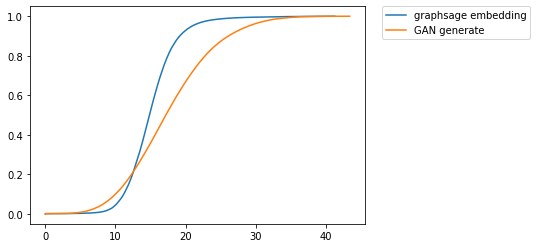

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.21782368 0.        ]
 [0.         0.         0.7453077  2.3236847  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.003458853
5.462181172542637e-05
0.0021019575563211556
save: 38
mmd=0.005452,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:20000/50000

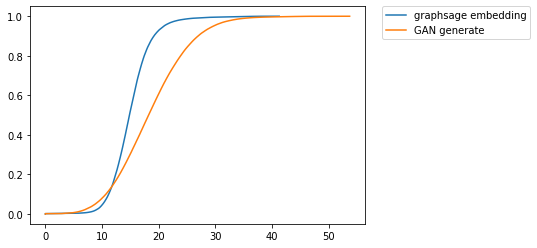

[[0.        0.        0.        2.4298174 0.       ]
 [0.        0.        0.        2.631682  0.       ]
 [0.        0.        0.        3.1234317 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0030214791
4.0957624337891656e-05
0.0021019575563211556
save: 39
mmd=0.005042,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:20500/50000

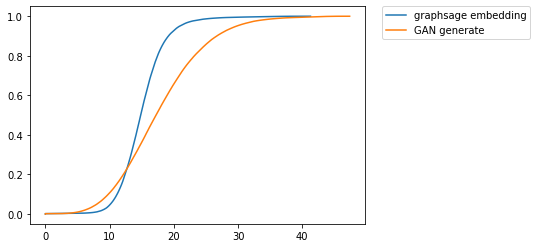

[[0.         0.         3.7734666  0.         0.78492635]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.9432452  0.84900945 0.0300811 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0038096271
5.240384552201937e-05
0.0021019575563211556
save: 40
mmd=0.005807,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:21000/50000

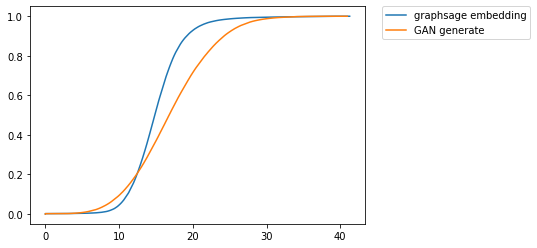

[[0.         0.         0.         1.8216048  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.53712916 0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0030701878
5.954094196401522e-05
0.0021019575563211556
save: 41
mmd=0.005053,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:21500/50000

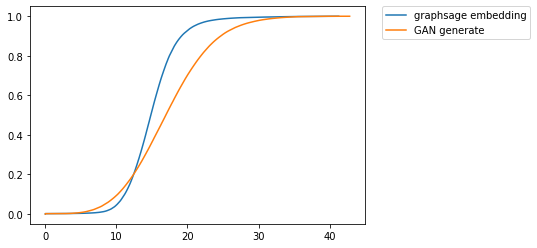

[[0.         0.         0.         0.4465716  0.        ]
 [0.         0.         3.0805     0.         0.44245327]
 [0.         0.         2.49663    0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.003138111
6.25110860670901e-05
0.0021019575563211556
save: 42
mmd=0.005115,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:22000/50000

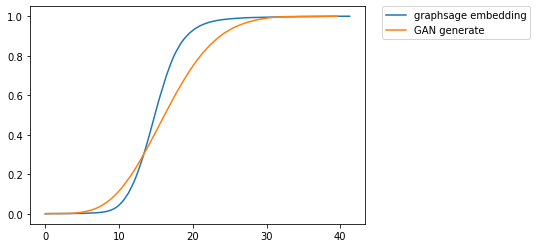

[[0.        0.        0.5680327 0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        1.7700521 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.003637225
7.079160719433975e-05
0.0021019575563211556
save: 43
mmd=0.005598,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:22500/50000

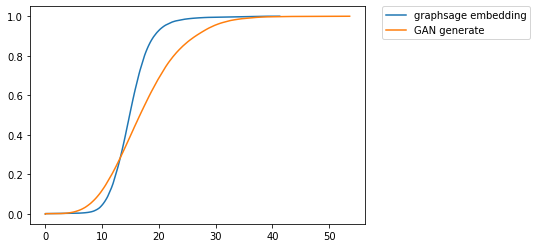

[[0.         0.         0.         3.400126   0.        ]
 [0.         0.         0.93207324 1.1324977  0.7590901 ]
 [0.         0.         0.         1.6382644  0.73678666]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0039041191
8.518707476371403e-05
0.0021019575563211556
save: 44
mmd=0.005836,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:23000/50000

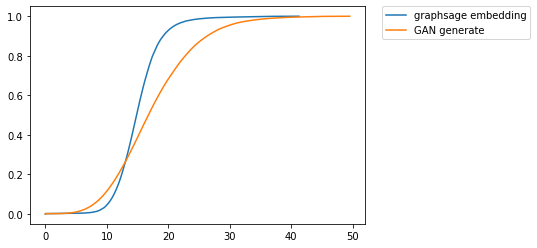

[[0.         0.         0.         2.812791   0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         1.047531   0.72161365 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0039200326
9.548734006996256e-05
0.0021019575563211556
save: 45
mmd=0.005831,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:23500/50000

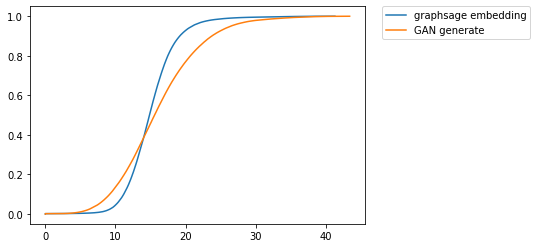

[[0.        0.        0.        2.6217895 0.       ]
 [0.        0.        0.        4.608681  0.       ]
 [0.        0.        0.3243185 0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0041136076
9.568697705414712e-05
0.0021019575563211556
save: 46
mmd=0.006024,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:24000/50000

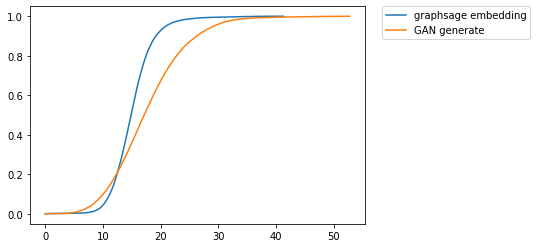

[[0.         0.         0.         0.         0.        ]
 [0.         0.         3.0096576  0.         0.65966475]
 [0.         0.         0.17466691 3.4927907  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0033114478
6.0182444668934873e-05
0.0021019575563211556
save: 47
mmd=0.005293,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:24500/50000

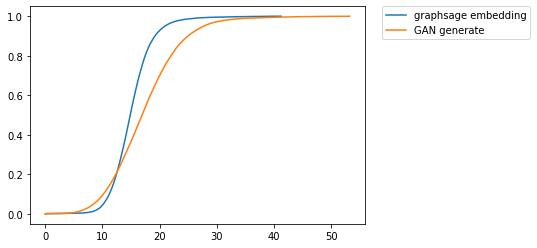

[[0.         0.         2.919505   0.         1.6897244 ]
 [0.         0.         0.         0.05426944 0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0031102775
8.806851161072482e-05
0.0021019575563211556
save: 48
mmd=0.005036,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:25000/50000

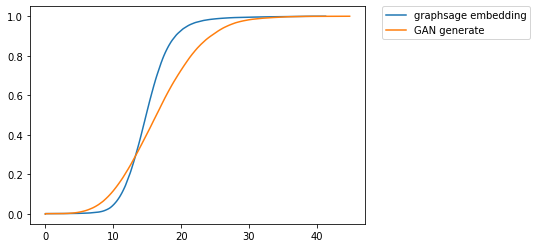

[[0.         0.         2.2827888  0.09742995 0.        ]
 [0.         0.         0.         2.6558497  0.        ]
 [0.         0.         1.9960115  3.1921837  0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.00370801
8.76864127474883e-05
0.0021019575563211556
save: 49
mmd=0.005635,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:25500/50000

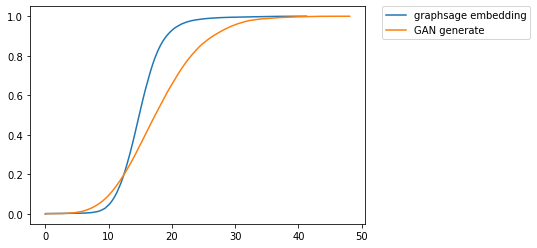

[[0.        0.        0.        2.677437  0.       ]
 [0.        0.        0.8810588 1.6481304 0.       ]
 [0.        0.        0.        0.        0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0033329276
9.635018724958549e-05
0.0021019575563211556
save: 50
mmd=0.005242,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:26000/50000

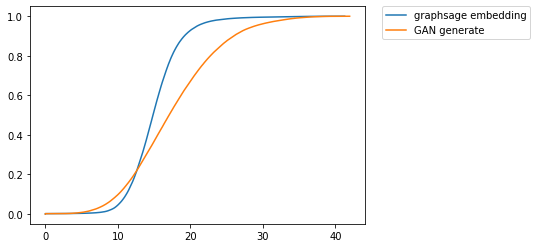

[[0.         0.         0.         7.375155   0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.40790695 0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0032976132
0.00010421960824668166
0.0021019575563211556
save: 51
mmd=0.005191,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:26500/50000

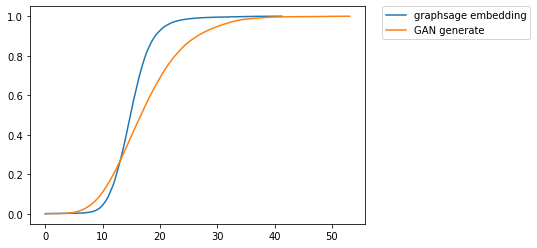

[[0.        0.        1.4244146 0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        3.6619825 1.3960274 0.       ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0034219886
0.00012485442105704872
0.0021019575563211556
save: 52
mmd=0.005274,collapse=0.001325


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:27000/50000

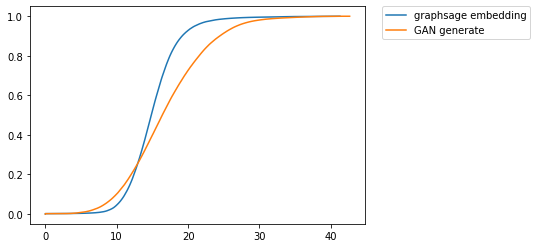

[[0.         0.         0.18011974 0.65493304 0.        ]
 [0.         0.         0.         4.483125   0.        ]
 [0.         0.         0.07119562 3.176616   0.5021262 ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0030932948
0.00013696449670577162
0.0021019575563211556
save: 53
mmd=0.004921,collapse=0.001325


In [14]:
import time
save_idx=0
global_best_mmd=10000
while(1):
    start_time=time.time()
    print(save_idx)
    flag,best_mmd=utils.gan_train(embeddings_training,batch_size=batch_size,noise_dim=noise_dim,
                                   g_hidden_dim=g_hidden_dim,d_hidden_dim=d_hidden_dim,
                                   lendataloader=lendataloader,Diter=Diter,Giter=Giter,epoch_numbers=epoch_numbers,eval_epoch=eval_epoch,
                                   save_idx=save_idx,learning_rate=1e-4,
                                   mmd_beta=0.1,mmd_criterion=0.03,mmd_best_criterion=0.005,most_training_epoch_number=50000,
                                 best_mmd=global_best_mmd,pretrained=False)
    if best_mmd<global_best_mmd:
        global_best_mmd=best_mmd
        
    if flag==True:
        break
    save_idx=save_idx+1
    print('Using time:%.2f'%(time.time()-start_time))
    print(best_mmd)
    print(global_best_mmd)

# **2.2 Load pretrained/trained gan model**

# *2.2.1 Load provided model*

In [15]:
netG = utils.Generator(noise_dim=noise_dim,embedding_dim=embedding_dim+2, g_hidden_dim=g_hidden_dim,batch_size=batch_size).cuda()

In [16]:
netG.load_state_dict(torch.load('gan_model/bestG.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'gan_model/bestG.pth'

# *2.2.2compute ECDF*

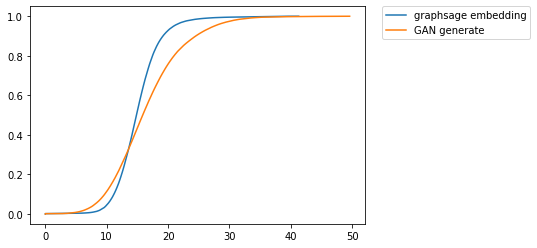

[[0.         0.         0.         0.10718694 0.        ]
 [0.         0.         1.4146508  0.         0.0714318 ]
 [0.         0.         1.9253126  0.         0.        ]]
[[0.00000000e+00 6.42150570e-38 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 0.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 0.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.0034496204
0.00016444762222890766
0.0021019575563211556


(0.0052226827580535784, 755)

In [17]:
utils.eval_plot(netG,embedding_matrix=embeddings_training,noise_dim=16,mmd_beta=0.1)

# **3.Sample**

# *3.1Generate embeddings*

In [18]:
noise= torch.randn(_N, noise_dim).cuda()
generate_data=netG(noise)
generate_data=generate_data.detach().to('cpu').numpy()
print(generate_data.shape)
print(generate_data[:10,128:])

(814, 130)
[[0.         0.06827411]
 [0.83352524 0.11919454]
 [0.51828355 0.40857115]
 [0.         0.48674816]
 [2.0381725  0.        ]
 [0.29141992 0.68819857]
 [0.         1.0084505 ]
 [1.8331199  0.        ]
 [0.         0.25611606]
 [3.31428    0.31970134]]


In [19]:
probability_matrix_generate=utils.generate_probability_matrix(_N,generate_data[:,:128],
                                                                        link_prediction_model)
_,graphic_seq_generate=utils.evaluate_overlap_torch_generate(_N,_num_of_edges,
                                                                                  probability_matrix_generate)

813/814[(1.0, 4, 7), (1.0, 4, 9), (1.0, 4, 72), (1.0, 4, 20), (1.0, 4, 37), (1.0, 4, 151), (1.0, 4, 152), (1.0, 4, 40), (1.0, 4, 50), (1.0, 4, 100)]
 max: (1.0, 126, 664) min: (1.0, 4, 7)


In [20]:
generate_graph=utils.revised_Havel_Hakimmi_Algorithm(_N,_num_of_edges,dic,probability_matrix_generate,graphic_seq_generate)

814
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[29, 21, 19, 19, 18, 18, 18, 16, 16, 16]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 5), (0, 10), (0, 11), (0, 13), (0, 17), (0, 18)]
[(79, 20), (79, 14), (78, 124), (66, 82), (61, 8), (59, 4), (58, 69), (55, 43), (55, 9), (49, 40)]
[[29, 20], [21, 14], [19, 124], [19, 82], [18, 69], [18, 8], [18, 4], [16, 43], [16, 40], [16, 9]]
[[1, 0], [1, 1], [1, 2], [1, 3], [1, 5], [1, 10], [1, 11], [1, 13], [1, 17], [1, 18]]
 remain_edge:0,x=6839992872.0
0.0
1436


In [21]:
tp=0
tn=0
fp=0
fn=0
for i in range(_N):
    for j in range(_N):
        if generate_graph[i,j]==1 and adj_origin[i,j]==1:
            tp=tp+1
        if generate_graph[i,j]==0 and adj_origin[i,j]==1:
            fp=fp+1
        if generate_graph[i,j]==1 and adj_origin[i,j]==0:
            fn=fn+1
        if generate_graph[i,j]==0 and adj_origin[i,j]==0:
            tn=tn+1
    print('\r%d/%d'%(i,_N),end="")
print('\n')
print('Edge overlap between generate graph and original graph')
print(generate_graph.shape)
total_num=_N*_N
print('True Positve:%d, %.2f'%(tp,tp/(tp+fp)))
print('False Positve:%d, %.2f'%(fp,fp/(tp+fp)))
print('True Negative:%d, %.2f'%(tn,tn/(tn+fn)))
print('False Negative:%d, %.2f'%(fn,fn/(tn+fn)))
print('Positive:%.2f'%((tp+fp)/total_num))
print('Negative:%.2f'%((tn+fn)/total_num))

813/814

Edge overlap between generate graph and original graph
(814, 814)
True Positve:6, 0.00
False Positve:2866, 1.00
True Negative:656858, 1.00
False Negative:2866, 0.00
Positive:0.00
Negative:1.00


In [22]:
metric_graphic_sq_generate=utils.compute_graph_statistics(generate_graph)
metric_graphic_sq_generate['edge_overlap']=tp/(tp+fp)

/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [23]:
for x in metric_origin:
    print('%-22s origin:%17.8f, link_pred:%17.8f, generate:%17.8f'%(x,metric_origin[x],
                                                                    metric_embedding[x],metric_graphic_sq_generate[x]))

d_max                  origin:      29.00000000, link_pred:      29.00000000, generate:      29.00000000
d_min                  origin:       1.00000000, link_pred:       0.00000000, generate:       1.00000000
d                      origin:       3.52825553, link_pred:       3.52825553, generate:       3.52825553
LCC                    origin:     814.00000000, link_pred:     806.00000000, generate:     606.00000000
wedge_count            origin:    7786.00000000, link_pred:    7526.00000000, generate:    7786.00000000
claw_count             origin:   23322.00000000, link_pred:   21661.00000000, generate:   23322.00000000
triangle_count         origin:     809.00000000, link_pred:     681.00000000, generate:      58.00000000
square_count           origin:     968.00000000, link_pred:     537.00000000, generate:       0.00000000
power_law_exp          origin:       2.05426571, link_pred:       2.03385673, generate:       2.05426571
gini                   origin:       0.42572701, link_p